<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfull

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-05-18 13:38:16--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-05-18 13:38:16--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  80.3MB/s    in 7.0s    

2023-05-18 13:38:23 (64.2 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [ ]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [ ]:
import os
import math
import random

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:03<00:00, 26.69it/s]


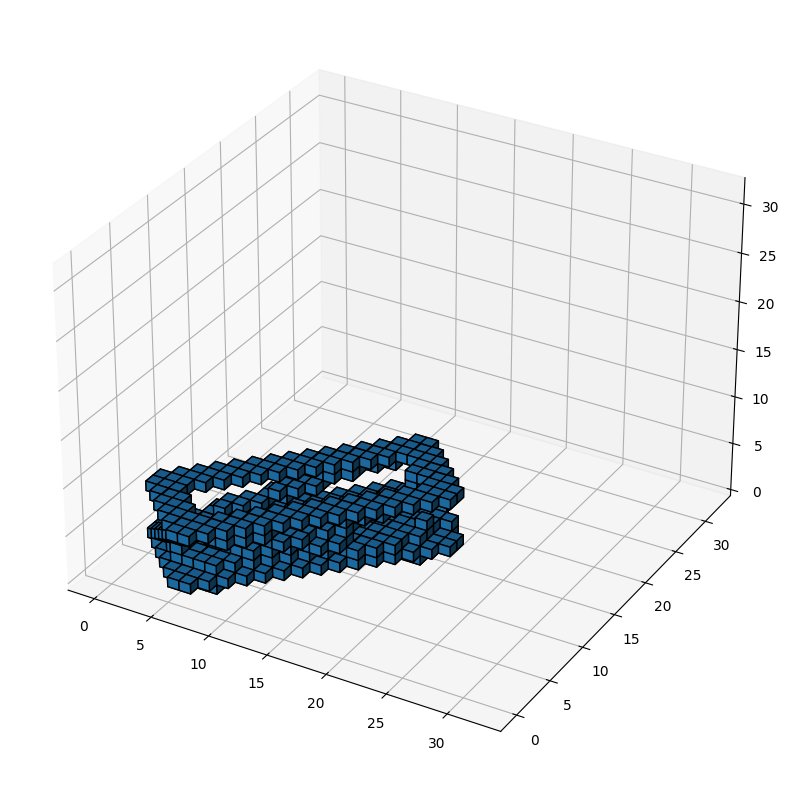

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [ ]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
   

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [ ]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=1)),
            ('drop2', torch.nn.Dropout(p=0.4))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
62.359375


Train loss: 1.1524598598480225: : 62it [00:19,  3.22it/s]
29it [00:01, 15.46it/s]


epoch:  1 / 50
time: 21.16 seconds
train-loss: 1.75, train-acc-object: 38.91%, train-acc-pose: 30.14%
valid-loss: 1.40, valid-acc-object: 51.43%, train-acc-pose: 50.55%



Train loss: 0.7939380407333374: : 62it [00:15,  3.89it/s]
29it [00:01, 15.37it/s]


epoch:  2 / 50
time: 17.85 seconds
train-loss: 1.11, train-acc-object: 61.92%, train-acc-pose: 52.32%
valid-loss: 1.07, valid-acc-object: 59.47%, train-acc-pose: 59.58%



Train loss: 0.8163546323776245: : 62it [00:13,  4.49it/s]
29it [00:04,  6.15it/s]


epoch:  3 / 50
time: 18.56 seconds
train-loss: 0.91, train-acc-object: 68.42%, train-acc-pose: 62.15%
valid-loss: 0.88, valid-acc-object: 67.84%, train-acc-pose: 60.79%



Train loss: 0.8096746802330017: : 62it [00:13,  4.67it/s]
29it [00:03,  8.96it/s]


epoch:  4 / 50
time: 16.55 seconds
train-loss: 0.77, train-acc-object: 74.45%, train-acc-pose: 67.79%
valid-loss: 0.77, valid-acc-object: 75.44%, train-acc-pose: 66.52%



Train loss: 0.6015316843986511: : 62it [00:10,  6.14it/s]
29it [00:02, 11.25it/s]


epoch:  5 / 50
time: 12.69 seconds
train-loss: 0.66, train-acc-object: 78.60%, train-acc-pose: 70.59%
valid-loss: 0.75, valid-acc-object: 73.35%, train-acc-pose: 69.05%



Train loss: 0.40580570697784424: : 62it [00:12,  4.98it/s]
29it [00:01, 15.07it/s]


epoch:  6 / 50
time: 14.39 seconds
train-loss: 0.55, train-acc-object: 82.16%, train-acc-pose: 73.99%
valid-loss: 0.68, valid-acc-object: 75.77%, train-acc-pose: 69.05%



Train loss: 0.5286678075790405: : 62it [00:11,  5.61it/s]
29it [00:01, 15.56it/s]


epoch:  7 / 50
time: 12.94 seconds
train-loss: 0.50, train-acc-object: 85.03%, train-acc-pose: 77.12%
valid-loss: 0.65, valid-acc-object: 78.63%, train-acc-pose: 71.37%



Train loss: 0.4202081561088562: : 62it [00:11,  5.52it/s]
29it [00:01, 15.68it/s]


epoch:  8 / 50
time: 13.10 seconds
train-loss: 0.47, train-acc-object: 85.36%, train-acc-pose: 77.87%
valid-loss: 0.65, valid-acc-object: 79.07%, train-acc-pose: 70.81%



Train loss: 0.3653455376625061: : 62it [00:11,  5.54it/s]
29it [00:01, 15.36it/s]


epoch:  9 / 50
time: 13.10 seconds
train-loss: 0.45, train-acc-object: 86.04%, train-acc-pose: 79.06%
valid-loss: 0.65, valid-acc-object: 78.19%, train-acc-pose: 70.59%



Train loss: 0.33927270770072937: : 62it [00:11,  5.32it/s]
29it [00:01, 15.13it/s]


epoch: 10 / 50
time: 13.59 seconds
train-loss: 0.41, train-acc-object: 87.40%, train-acc-pose: 79.18%
valid-loss: 0.63, valid-acc-object: 79.96%, train-acc-pose: 72.80%



Train loss: 0.27855750918388367: : 62it [00:11,  5.58it/s]
29it [00:01, 15.30it/s]


epoch: 11 / 50
time: 13.03 seconds
train-loss: 0.36, train-acc-object: 88.81%, train-acc-pose: 81.70%
valid-loss: 0.62, valid-acc-object: 79.96%, train-acc-pose: 73.57%



Train loss: 0.2543838918209076: : 62it [00:10,  5.73it/s]
29it [00:02, 12.72it/s]


epoch: 12 / 50
time: 13.11 seconds
train-loss: 0.34, train-acc-object: 90.17%, train-acc-pose: 82.13%
valid-loss: 0.61, valid-acc-object: 81.39%, train-acc-pose: 73.90%



Train loss: 0.3559873104095459: : 62it [00:09,  6.21it/s]
29it [00:03,  9.32it/s]


epoch: 13 / 50
time: 13.12 seconds
train-loss: 0.33, train-acc-object: 90.15%, train-acc-pose: 83.37%
valid-loss: 0.62, valid-acc-object: 81.50%, train-acc-pose: 74.34%



Train loss: 0.4178796410560608: : 62it [00:09,  6.51it/s]
29it [00:02, 10.07it/s]


epoch: 14 / 50
time: 12.43 seconds
train-loss: 0.32, train-acc-object: 90.52%, train-acc-pose: 83.06%
valid-loss: 0.63, valid-acc-object: 79.63%, train-acc-pose: 74.01%



Train loss: 0.2960238754749298: : 62it [00:10,  6.03it/s]
29it [00:01, 15.40it/s]


epoch: 15 / 50
time: 12.17 seconds
train-loss: 0.30, train-acc-object: 90.55%, train-acc-pose: 83.97%
valid-loss: 0.63, valid-acc-object: 80.51%, train-acc-pose: 74.01%



Train loss: 0.3552205264568329: : 62it [00:11,  5.51it/s]
29it [00:01, 15.21it/s]


epoch: 16 / 50
time: 13.19 seconds
train-loss: 0.29, train-acc-object: 91.08%, train-acc-pose: 84.68%
valid-loss: 0.61, valid-acc-object: 81.17%, train-acc-pose: 74.78%



Train loss: 0.18629086017608643: : 62it [00:11,  5.57it/s]
29it [00:01, 15.05it/s]


epoch: 17 / 50
time: 13.08 seconds
train-loss: 0.27, train-acc-object: 92.62%, train-acc-pose: 85.64%
valid-loss: 0.63, valid-acc-object: 81.83%, train-acc-pose: 74.12%



Train loss: 0.4260464608669281: : 62it [00:12,  4.99it/s]
29it [00:01, 15.20it/s]


epoch: 18 / 50
time: 14.34 seconds
train-loss: 0.27, train-acc-object: 92.39%, train-acc-pose: 85.69%
valid-loss: 0.62, valid-acc-object: 82.27%, train-acc-pose: 74.56%



Train loss: 0.29196682572364807: : 62it [00:11,  5.47it/s]
29it [00:01, 15.10it/s]


epoch: 19 / 50
time: 13.26 seconds
train-loss: 0.26, train-acc-object: 92.39%, train-acc-pose: 85.61%
valid-loss: 0.63, valid-acc-object: 82.38%, train-acc-pose: 74.23%



Train loss: 0.19911696016788483: : 62it [00:11,  5.47it/s]
29it [00:01, 15.00it/s]


epoch: 20 / 50
time: 13.28 seconds
train-loss: 0.26, train-acc-object: 92.99%, train-acc-pose: 86.21%
valid-loss: 0.64, valid-acc-object: 81.72%, train-acc-pose: 73.35%



Train loss: 0.2672300338745117: : 62it [00:11,  5.60it/s]
29it [00:01, 14.53it/s]


epoch: 21 / 50
time: 13.09 seconds
train-loss: 0.25, train-acc-object: 92.34%, train-acc-pose: 87.20%
valid-loss: 0.62, valid-acc-object: 82.71%, train-acc-pose: 75.44%



Train loss: 0.19036880135536194: : 62it [00:10,  5.97it/s]
29it [00:02, 10.17it/s]


epoch: 22 / 50
time: 13.26 seconds
train-loss: 0.24, train-acc-object: 93.40%, train-acc-pose: 86.84%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.23%



Train loss: 0.20973344147205353: : 62it [00:09,  6.53it/s]
29it [00:03,  9.05it/s]


epoch: 23 / 50
time: 12.71 seconds
train-loss: 0.23, train-acc-object: 93.83%, train-acc-pose: 86.77%
valid-loss: 0.62, valid-acc-object: 82.38%, train-acc-pose: 75.00%



Train loss: 0.2884109318256378: : 62it [00:10,  6.15it/s]
29it [00:02, 12.75it/s]


epoch: 24 / 50
time: 12.37 seconds
train-loss: 0.24, train-acc-object: 92.97%, train-acc-pose: 86.97%
valid-loss: 0.63, valid-acc-object: 81.61%, train-acc-pose: 73.57%



Train loss: 0.24183546006679535: : 62it [00:10,  5.70it/s]
29it [00:01, 15.17it/s]


epoch: 25 / 50
time: 12.81 seconds
train-loss: 0.23, train-acc-object: 93.78%, train-acc-pose: 86.92%
valid-loss: 0.63, valid-acc-object: 82.27%, train-acc-pose: 74.12%



Train loss: 0.25598591566085815: : 62it [00:11,  5.48it/s]
29it [00:01, 14.69it/s]


epoch: 26 / 50
time: 13.32 seconds
train-loss: 0.23, train-acc-object: 93.60%, train-acc-pose: 87.90%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 73.90%



Train loss: 0.24919435381889343: : 62it [00:11,  5.42it/s]
29it [00:01, 14.59it/s]


epoch: 27 / 50
time: 13.45 seconds
train-loss: 0.22, train-acc-object: 93.70%, train-acc-pose: 87.78%
valid-loss: 0.63, valid-acc-object: 82.71%, train-acc-pose: 74.67%



Train loss: 0.21166688203811646: : 62it [00:11,  5.45it/s]
29it [00:02, 11.90it/s]


epoch: 28 / 50
time: 13.83 seconds
train-loss: 0.22, train-acc-object: 93.80%, train-acc-pose: 87.47%
valid-loss: 0.63, valid-acc-object: 82.60%, train-acc-pose: 74.78%



Train loss: 0.29538652300834656: : 62it [00:12,  4.90it/s]
29it [00:01, 14.80it/s]


epoch: 29 / 50
time: 14.63 seconds
train-loss: 0.22, train-acc-object: 93.85%, train-acc-pose: 87.98%
valid-loss: 0.63, valid-acc-object: 82.27%, train-acc-pose: 74.56%



Train loss: 0.19263288378715515: : 62it [00:11,  5.48it/s]
29it [00:01, 14.72it/s]


epoch: 30 / 50
time: 13.30 seconds
train-loss: 0.22, train-acc-object: 94.10%, train-acc-pose: 88.21%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 74.01%



Train loss: 0.17727938294410706: : 62it [00:11,  5.44it/s]
29it [00:01, 14.76it/s]


epoch: 31 / 50
time: 13.39 seconds
train-loss: 0.21, train-acc-object: 94.25%, train-acc-pose: 88.10%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 74.34%



Train loss: 0.19792139530181885: : 62it [00:10,  5.65it/s]
29it [00:02, 11.93it/s]


epoch: 32 / 50
time: 13.42 seconds
train-loss: 0.22, train-acc-object: 94.35%, train-acc-pose: 87.55%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.45%



Train loss: 0.25294265151023865: : 62it [00:10,  5.96it/s]
29it [00:03,  8.97it/s]


epoch: 33 / 50
time: 13.66 seconds
train-loss: 0.22, train-acc-object: 94.03%, train-acc-pose: 88.28%
valid-loss: 0.63, valid-acc-object: 81.94%, train-acc-pose: 74.56%



Train loss: 0.23372305929660797: : 62it [00:09,  6.29it/s]
29it [00:03,  8.78it/s]


epoch: 34 / 50
time: 13.18 seconds
train-loss: 0.21, train-acc-object: 94.33%, train-acc-pose: 88.41%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 74.23%



Train loss: 0.21458950638771057: : 62it [00:10,  6.00it/s]
29it [00:02, 11.23it/s]


epoch: 35 / 50
time: 12.94 seconds
train-loss: 0.21, train-acc-object: 94.08%, train-acc-pose: 88.28%
valid-loss: 0.63, valid-acc-object: 81.94%, train-acc-pose: 74.23%



Train loss: 0.17412126064300537: : 62it [00:10,  5.73it/s]
29it [00:01, 14.94it/s]


epoch: 36 / 50
time: 12.79 seconds
train-loss: 0.21, train-acc-object: 93.88%, train-acc-pose: 88.43%
valid-loss: 0.63, valid-acc-object: 81.94%, train-acc-pose: 74.45%



Train loss: 0.1368531882762909: : 62it [00:11,  5.42it/s]
29it [00:01, 14.54it/s]


epoch: 37 / 50
time: 13.44 seconds
train-loss: 0.21, train-acc-object: 94.23%, train-acc-pose: 88.81%
valid-loss: 0.63, valid-acc-object: 81.94%, train-acc-pose: 74.56%



Train loss: 0.19735689461231232: : 62it [00:11,  5.42it/s]
29it [00:01, 14.84it/s]


epoch: 38 / 50
time: 13.42 seconds
train-loss: 0.21, train-acc-object: 94.33%, train-acc-pose: 87.73%
valid-loss: 0.63, valid-acc-object: 81.94%, train-acc-pose: 74.56%



Train loss: 0.11843954026699066: : 62it [00:11,  5.41it/s]
29it [00:01, 14.71it/s]


epoch: 39 / 50
time: 13.46 seconds
train-loss: 0.21, train-acc-object: 94.20%, train-acc-pose: 87.98%
valid-loss: 0.63, valid-acc-object: 81.83%, train-acc-pose: 74.67%



Train loss: 0.23585569858551025: : 62it [00:11,  5.43it/s]
29it [00:01, 14.67it/s]


epoch: 40 / 50
time: 13.40 seconds
train-loss: 0.20, train-acc-object: 94.76%, train-acc-pose: 88.46%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.56%



Train loss: 0.2190154790878296: : 62it [00:11,  5.36it/s]
29it [00:01, 14.86it/s]


epoch: 41 / 50
time: 13.54 seconds
train-loss: 0.20, train-acc-object: 94.71%, train-acc-pose: 87.93%
valid-loss: 0.64, valid-acc-object: 82.16%, train-acc-pose: 74.45%



Train loss: 0.19774016737937927: : 62it [00:11,  5.45it/s]
29it [00:01, 14.52it/s]


epoch: 42 / 50
time: 13.39 seconds
train-loss: 0.21, train-acc-object: 94.20%, train-acc-pose: 88.63%
valid-loss: 0.64, valid-acc-object: 82.16%, train-acc-pose: 74.45%



Train loss: 0.1789650321006775: : 62it [00:10,  5.74it/s]
29it [00:02, 10.34it/s]


epoch: 43 / 50
time: 13.61 seconds
train-loss: 0.21, train-acc-object: 94.53%, train-acc-pose: 88.36%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.34%



Train loss: 0.22394736111164093: : 62it [00:10,  6.08it/s]
29it [00:03,  8.63it/s]


epoch: 44 / 50
time: 13.58 seconds
train-loss: 0.21, train-acc-object: 94.58%, train-acc-pose: 88.31%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 74.34%



Train loss: 0.19225165247917175: : 62it [00:09,  6.23it/s]
29it [00:02,  9.78it/s]


epoch: 45 / 50
time: 12.94 seconds
train-loss: 0.20, train-acc-object: 94.56%, train-acc-pose: 88.89%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.34%



Train loss: 0.21157719194889069: : 62it [00:10,  5.88it/s]
29it [00:02, 13.49it/s]


epoch: 46 / 50
time: 12.71 seconds
train-loss: 0.21, train-acc-object: 94.15%, train-acc-pose: 88.38%
valid-loss: 0.63, valid-acc-object: 82.16%, train-acc-pose: 74.45%



Train loss: 0.23810975253582: : 62it [00:11,  5.50it/s]
29it [00:01, 14.69it/s]


epoch: 47 / 50
time: 13.26 seconds
train-loss: 0.20, train-acc-object: 94.51%, train-acc-pose: 88.89%
valid-loss: 0.63, valid-acc-object: 82.05%, train-acc-pose: 74.56%



Train loss: 0.14383912086486816: : 62it [00:11,  5.43it/s]
29it [00:01, 14.80it/s]


epoch: 48 / 50
time: 13.39 seconds
train-loss: 0.21, train-acc-object: 94.30%, train-acc-pose: 89.14%
valid-loss: 0.64, valid-acc-object: 82.05%, train-acc-pose: 74.45%



Train loss: 0.2446347326040268: : 62it [00:11,  5.42it/s]
29it [00:01, 14.89it/s]


epoch: 49 / 50
time: 13.42 seconds
train-loss: 0.21, train-acc-object: 94.28%, train-acc-pose: 88.99%
valid-loss: 0.64, valid-acc-object: 82.16%, train-acc-pose: 74.45%



Train loss: 0.284258633852005: : 62it [00:11,  5.40it/s]
29it [00:01, 14.54it/s]

epoch: 50 / 50
time: 13.49 seconds
train-loss: 0.21, train-acc-object: 94.51%, train-acc-pose: 89.09%
valid-loss: 0.64, valid-acc-object: 82.16%, train-acc-pose: 74.23%



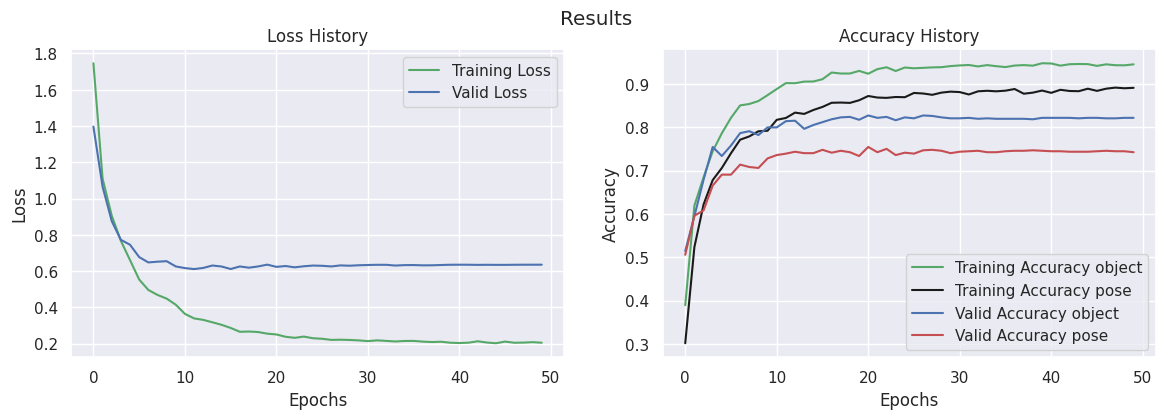

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 21
with a validation loss of: 0.6232937 and a validation accuracy of: 82.70925283432007


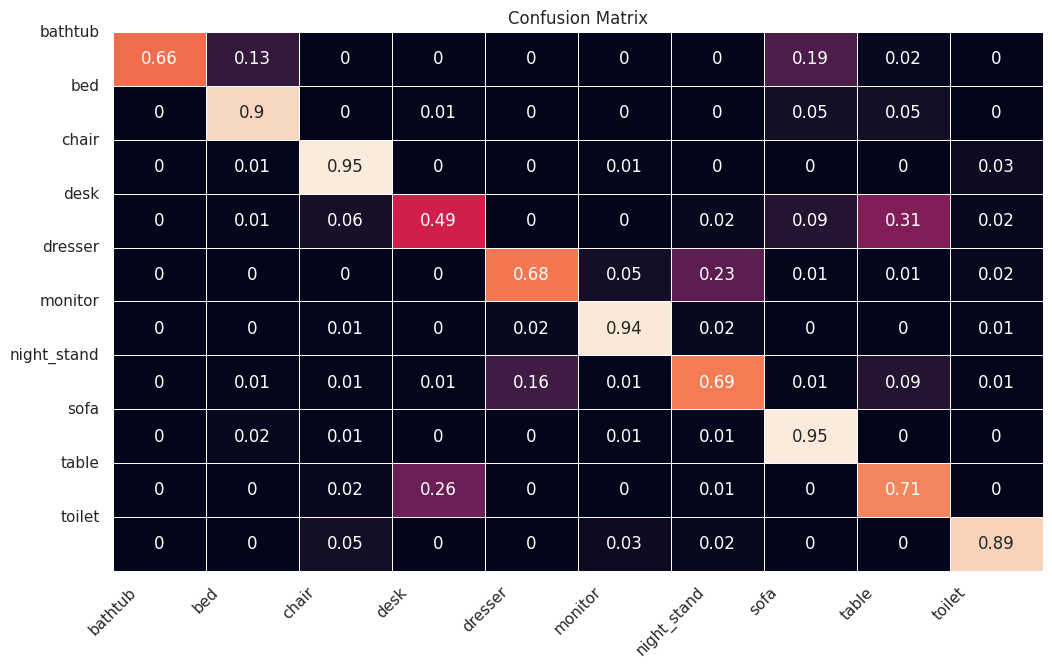

In [ ]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 21
with a validation loss of: 0.6232937 and a validation accuracy of: 82.70925283432007


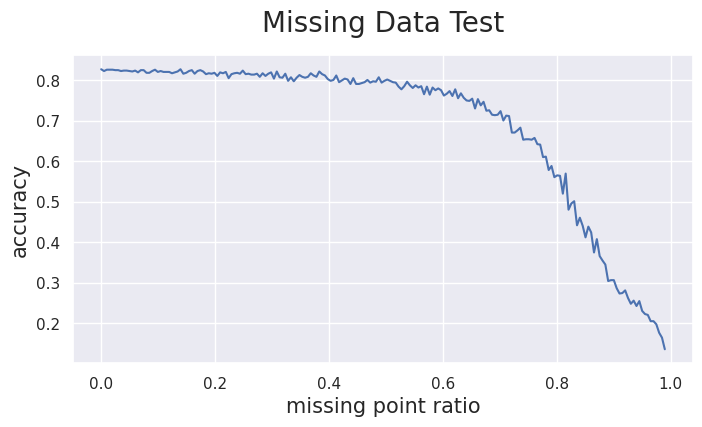

In [ ]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [ ]:
from collections import OrderedDict
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.2083286046981812: : 62it [00:18,  3.44it/s]
29it [00:02, 13.34it/s]


epoch:  1 / 50
time: 20.19 seconds
train-loss: 1.57, train-acc-object: 46.17%, train-acc-pose: 36.32%
valid-loss: 1.56, valid-acc-object: 52.86%, train-acc-pose: 50.66%



Train loss: 0.8488363027572632: : 62it [00:17,  3.62it/s]
29it [00:02, 13.39it/s]


epoch:  2 / 50
time: 19.32 seconds
train-loss: 0.98, train-acc-object: 67.69%, train-acc-pose: 55.42%
valid-loss: 0.94, valid-acc-object: 70.15%, train-acc-pose: 60.02%



Train loss: 0.7358862161636353: : 62it [00:17,  3.57it/s]
29it [00:03,  8.02it/s]


epoch:  3 / 50
time: 21.02 seconds
train-loss: 0.77, train-acc-object: 73.56%, train-acc-pose: 66.18%
valid-loss: 0.89, valid-acc-object: 67.95%, train-acc-pose: 63.55%



Train loss: 0.7601144313812256: : 62it [00:17,  3.57it/s]
29it [00:02, 13.19it/s]


epoch:  4 / 50
time: 19.60 seconds
train-loss: 0.64, train-acc-object: 78.65%, train-acc-pose: 71.19%
valid-loss: 0.73, valid-acc-object: 74.12%, train-acc-pose: 65.20%



Train loss: 0.5732424259185791: : 62it [00:17,  3.54it/s]
29it [00:04,  7.16it/s]


epoch:  5 / 50
time: 21.58 seconds
train-loss: 0.53, train-acc-object: 82.86%, train-acc-pose: 74.55%
valid-loss: 0.68, valid-acc-object: 78.74%, train-acc-pose: 68.83%



Train loss: 0.3696765899658203: : 62it [00:18,  3.40it/s]
29it [00:02, 13.07it/s]


epoch:  6 / 50
time: 20.46 seconds
train-loss: 0.43, train-acc-object: 86.06%, train-acc-pose: 78.15%
valid-loss: 0.57, valid-acc-object: 78.30%, train-acc-pose: 71.26%



Train loss: 0.35104483366012573: : 62it [00:17,  3.53it/s]
29it [00:02, 13.09it/s]


epoch:  7 / 50
time: 19.80 seconds
train-loss: 0.37, train-acc-object: 88.63%, train-acc-pose: 79.96%
valid-loss: 0.56, valid-acc-object: 82.93%, train-acc-pose: 72.47%



Train loss: 0.44112157821655273: : 62it [00:17,  3.49it/s]
29it [00:03,  7.97it/s]


epoch:  8 / 50
time: 21.40 seconds
train-loss: 0.34, train-acc-object: 89.62%, train-acc-pose: 81.63%
valid-loss: 0.53, valid-acc-object: 83.04%, train-acc-pose: 73.02%



Train loss: 0.2710649371147156: : 62it [00:17,  3.58it/s]
29it [00:02, 12.96it/s]


epoch:  9 / 50
time: 19.60 seconds
train-loss: 0.32, train-acc-object: 90.70%, train-acc-pose: 82.69%
valid-loss: 0.52, valid-acc-object: 82.16%, train-acc-pose: 74.23%



Train loss: 0.3392419219017029: : 62it [00:17,  3.55it/s]
29it [00:02, 11.76it/s]


epoch: 10 / 50
time: 19.97 seconds
train-loss: 0.28, train-acc-object: 92.11%, train-acc-pose: 83.22%
valid-loss: 0.51, valid-acc-object: 82.49%, train-acc-pose: 75.44%



Train loss: 0.33668434619903564: : 62it [00:18,  3.38it/s]
29it [00:02, 12.80it/s]


epoch: 11 / 50
time: 20.63 seconds
train-loss: 0.25, train-acc-object: 93.52%, train-acc-pose: 84.83%
valid-loss: 0.50, valid-acc-object: 83.70%, train-acc-pose: 76.10%



Train loss: 0.3421209454536438: : 62it [00:17,  3.56it/s]
29it [00:02, 13.01it/s]


epoch: 12 / 50
time: 19.66 seconds
train-loss: 0.24, train-acc-object: 93.40%, train-acc-pose: 86.01%
valid-loss: 0.50, valid-acc-object: 83.04%, train-acc-pose: 76.76%



Train loss: 0.214183509349823: : 62it [00:17,  3.54it/s]
29it [00:03,  7.67it/s]


epoch: 13 / 50
time: 21.31 seconds
train-loss: 0.21, train-acc-object: 94.98%, train-acc-pose: 86.49%
valid-loss: 0.49, valid-acc-object: 84.47%, train-acc-pose: 75.99%



Train loss: 0.2208898663520813: : 62it [00:17,  3.54it/s]
29it [00:02, 12.78it/s]


epoch: 14 / 50
time: 19.78 seconds
train-loss: 0.22, train-acc-object: 93.98%, train-acc-pose: 87.75%
valid-loss: 0.49, valid-acc-object: 84.14%, train-acc-pose: 75.66%



Train loss: 0.20436447858810425: : 62it [00:17,  3.54it/s]
29it [00:02, 12.51it/s]


epoch: 15 / 50
time: 19.87 seconds
train-loss: 0.21, train-acc-object: 94.53%, train-acc-pose: 86.95%
valid-loss: 0.49, valid-acc-object: 83.59%, train-acc-pose: 76.54%



Train loss: 0.15280365943908691: : 62it [00:18,  3.33it/s]
29it [00:02, 12.17it/s]


epoch: 16 / 50
time: 21.04 seconds
train-loss: 0.19, train-acc-object: 95.19%, train-acc-pose: 88.51%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 76.98%



Train loss: 0.17717181146144867: : 62it [00:17,  3.52it/s]
29it [00:02, 13.05it/s]


epoch: 17 / 50
time: 19.87 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 89.39%
valid-loss: 0.48, valid-acc-object: 84.36%, train-acc-pose: 76.76%



Train loss: 0.1274399757385254: : 62it [00:17,  3.53it/s]
29it [00:03,  7.63it/s]


epoch: 18 / 50
time: 21.40 seconds
train-loss: 0.18, train-acc-object: 95.54%, train-acc-pose: 88.99%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 77.42%



Train loss: 0.2702512741088867: : 62it [00:17,  3.52it/s]
29it [00:02, 12.98it/s]


epoch: 19 / 50
time: 19.88 seconds
train-loss: 0.18, train-acc-object: 95.77%, train-acc-pose: 88.36%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 77.20%



Train loss: 0.20068511366844177: : 62it [00:18,  3.30it/s]
29it [00:03,  8.79it/s]


epoch: 20 / 50
time: 22.10 seconds
train-loss: 0.17, train-acc-object: 95.74%, train-acc-pose: 89.64%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 77.53%



Train loss: 0.16444182395935059: : 62it [00:18,  3.43it/s]
29it [00:02, 12.60it/s]


epoch: 21 / 50
time: 20.42 seconds
train-loss: 0.16, train-acc-object: 95.99%, train-acc-pose: 89.79%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.86%



Train loss: 0.26732370257377625: : 62it [00:17,  3.54it/s]
29it [00:02, 12.79it/s]


epoch: 22 / 50
time: 19.82 seconds
train-loss: 0.16, train-acc-object: 96.67%, train-acc-pose: 89.87%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 78.19%



Train loss: 0.21769781410694122: : 62it [00:18,  3.39it/s]
29it [00:02, 10.06it/s]


epoch: 23 / 50
time: 21.19 seconds
train-loss: 0.16, train-acc-object: 96.32%, train-acc-pose: 89.79%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 78.30%



Train loss: 0.119288370013237: : 62it [00:17,  3.51it/s]
29it [00:02, 12.34it/s]


epoch: 24 / 50
time: 20.01 seconds
train-loss: 0.15, train-acc-object: 96.35%, train-acc-pose: 90.02%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 76.98%



Train loss: 0.16561371088027954: : 62it [00:17,  3.49it/s]
29it [00:03,  7.64it/s]


epoch: 25 / 50
time: 21.57 seconds
train-loss: 0.15, train-acc-object: 96.52%, train-acc-pose: 89.97%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 77.97%



Train loss: 0.1477731317281723: : 62it [00:17,  3.47it/s]
29it [00:02, 12.73it/s]


epoch: 26 / 50
time: 20.18 seconds
train-loss: 0.15, train-acc-object: 96.57%, train-acc-pose: 90.70%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 77.86%



Train loss: 0.1175965666770935: : 62it [00:17,  3.50it/s]
29it [00:02, 11.19it/s]


epoch: 27 / 50
time: 20.35 seconds
train-loss: 0.15, train-acc-object: 96.42%, train-acc-pose: 90.65%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 77.64%



Train loss: 0.15484946966171265: : 62it [00:18,  3.35it/s]
29it [00:02, 12.74it/s]


epoch: 28 / 50
time: 20.82 seconds
train-loss: 0.15, train-acc-object: 96.93%, train-acc-pose: 90.50%
valid-loss: 0.48, valid-acc-object: 85.13%, train-acc-pose: 77.97%



Train loss: 0.11000905930995941: : 62it [00:17,  3.47it/s]
29it [00:02, 12.55it/s]


epoch: 29 / 50
time: 20.19 seconds
train-loss: 0.14, train-acc-object: 97.28%, train-acc-pose: 90.62%
valid-loss: 0.48, valid-acc-object: 85.13%, train-acc-pose: 77.31%



Train loss: 0.11082291603088379: : 62it [00:18,  3.40it/s]
29it [00:03,  8.30it/s]


epoch: 30 / 50
time: 21.76 seconds
train-loss: 0.13, train-acc-object: 97.30%, train-acc-pose: 90.95%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 77.75%



Train loss: 0.09938982874155045: : 62it [00:17,  3.49it/s]
29it [00:02, 12.77it/s]


epoch: 31 / 50
time: 20.05 seconds
train-loss: 0.14, train-acc-object: 96.67%, train-acc-pose: 91.61%
valid-loss: 0.48, valid-acc-object: 84.47%, train-acc-pose: 76.98%



Train loss: 0.09683699905872345: : 62it [00:17,  3.49it/s]
29it [00:03,  8.35it/s]


epoch: 32 / 50
time: 21.27 seconds
train-loss: 0.13, train-acc-object: 97.56%, train-acc-pose: 91.43%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.20%



Train loss: 0.10638485848903656: : 62it [00:18,  3.40it/s]
29it [00:02, 12.59it/s]


epoch: 33 / 50
time: 20.54 seconds
train-loss: 0.14, train-acc-object: 97.15%, train-acc-pose: 90.50%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.53%



Train loss: 0.13349339365959167: : 62it [00:17,  3.48it/s]
29it [00:02, 12.26it/s]


epoch: 34 / 50
time: 20.22 seconds
train-loss: 0.14, train-acc-object: 96.85%, train-acc-pose: 90.42%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.75%



Train loss: 0.12340593338012695: : 62it [00:20,  3.09it/s]
29it [00:02, 12.31it/s]


epoch: 35 / 50
time: 22.46 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 91.13%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.20%



Train loss: 0.2450370490550995: : 62it [00:17,  3.46it/s]
29it [00:02, 12.40it/s]


epoch: 36 / 50
time: 20.29 seconds
train-loss: 0.14, train-acc-object: 97.15%, train-acc-pose: 90.68%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.42%



Train loss: 0.1854824423789978: : 62it [00:18,  3.36it/s]
29it [00:03,  8.51it/s]


epoch: 37 / 50
time: 21.89 seconds
train-loss: 0.14, train-acc-object: 97.13%, train-acc-pose: 91.56%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 77.31%



Train loss: 0.1166846752166748: : 62it [00:17,  3.45it/s]
29it [00:02, 12.40it/s]


epoch: 38 / 50
time: 20.35 seconds
train-loss: 0.14, train-acc-object: 97.10%, train-acc-pose: 91.23%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 77.42%



Train loss: 0.1146446168422699: : 62it [00:17,  3.46it/s]
29it [00:03,  7.59it/s]


epoch: 39 / 50
time: 21.75 seconds
train-loss: 0.13, train-acc-object: 97.25%, train-acc-pose: 91.08%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 77.42%



Train loss: 0.16483396291732788: : 62it [00:17,  3.45it/s]
29it [00:02, 12.13it/s]


epoch: 40 / 50
time: 20.40 seconds
train-loss: 0.13, train-acc-object: 96.93%, train-acc-pose: 91.58%
valid-loss: 0.48, valid-acc-object: 84.47%, train-acc-pose: 77.53%



Train loss: 0.1006779745221138: : 62it [00:17,  3.45it/s]
29it [00:03,  9.39it/s]


epoch: 41 / 50
time: 21.11 seconds
train-loss: 0.13, train-acc-object: 96.88%, train-acc-pose: 91.66%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 77.53%



Train loss: 0.1468467116355896: : 62it [00:18,  3.33it/s]
29it [00:02, 12.27it/s]


epoch: 42 / 50
time: 21.01 seconds
train-loss: 0.13, train-acc-object: 97.28%, train-acc-pose: 90.90%
valid-loss: 0.48, valid-acc-object: 84.69%, train-acc-pose: 77.97%



Train loss: 0.08494403213262558: : 62it [00:17,  3.46it/s]
29it [00:02, 12.08it/s]


epoch: 43 / 50
time: 20.34 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 90.35%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 77.86%



Train loss: 0.09365469217300415: : 62it [00:18,  3.28it/s]
29it [00:02, 11.47it/s]


epoch: 44 / 50
time: 21.47 seconds
train-loss: 0.13, train-acc-object: 96.88%, train-acc-pose: 91.00%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.97%



Train loss: 0.09250134229660034: : 62it [00:18,  3.44it/s]
29it [00:02, 12.38it/s]


epoch: 45 / 50
time: 20.39 seconds
train-loss: 0.14, train-acc-object: 96.67%, train-acc-pose: 91.26%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 77.97%



Train loss: 0.1082397848367691: : 62it [00:18,  3.35it/s]
29it [00:03,  8.13it/s]


epoch: 46 / 50
time: 22.07 seconds
train-loss: 0.13, train-acc-object: 97.30%, train-acc-pose: 91.78%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 78.08%



Train loss: 0.12614065408706665: : 62it [00:18,  3.43it/s]
29it [00:02, 12.04it/s]


epoch: 47 / 50
time: 20.51 seconds
train-loss: 0.13, train-acc-object: 96.85%, train-acc-pose: 91.58%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 78.08%



Train loss: 0.11670521646738052: : 62it [00:18,  3.40it/s]
29it [00:04,  7.17it/s]


epoch: 48 / 50
time: 22.32 seconds
train-loss: 0.14, train-acc-object: 96.98%, train-acc-pose: 91.33%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 78.08%



Train loss: 0.08966344594955444: : 62it [00:18,  3.39it/s]
29it [00:02, 11.80it/s]


epoch: 49 / 50
time: 20.76 seconds
train-loss: 0.14, train-acc-object: 97.25%, train-acc-pose: 91.26%
valid-loss: 0.48, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.1112884134054184: : 62it [00:19,  3.17it/s]
29it [00:03,  8.54it/s]

epoch: 50 / 50
time: 22.95 seconds
train-loss: 0.13, train-acc-object: 96.98%, train-acc-pose: 91.53%
valid-loss: 0.48, valid-acc-object: 85.02%, train-acc-pose: 77.97%



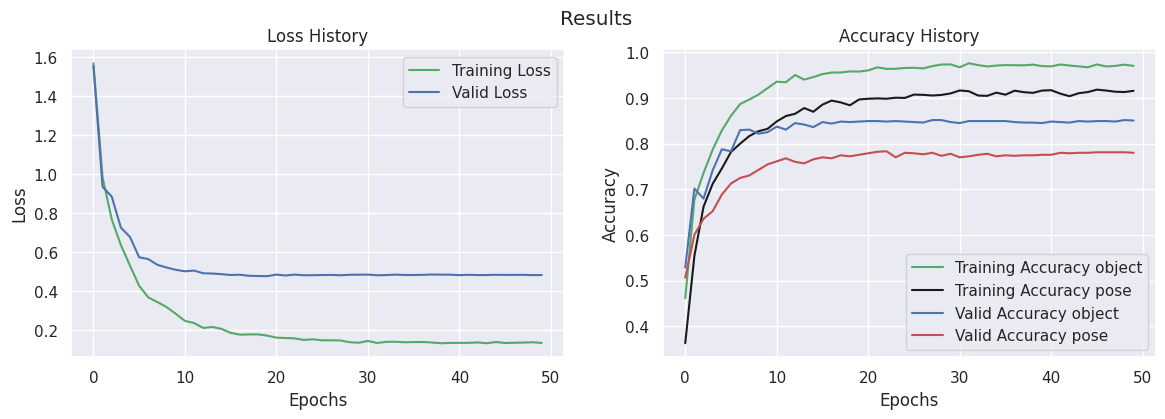

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 28
with a validation loss of: 0.48068425 and a validation accuracy of: 85.13215780258179


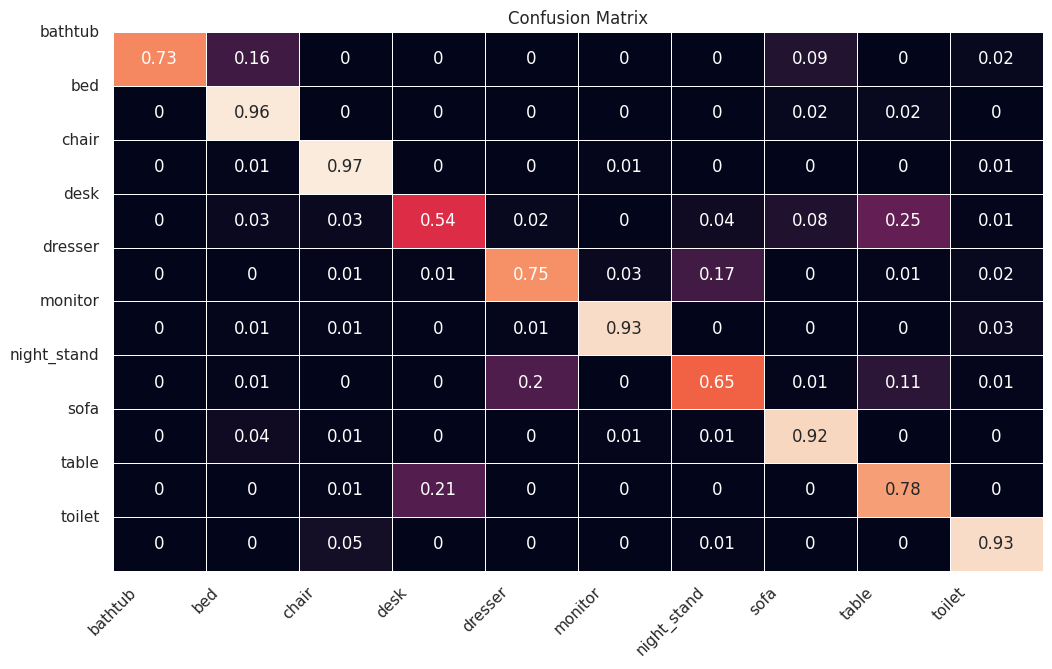

In [ ]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 28
with a validation loss of: 0.48068425 and a validation accuracy of: 85.13215780258179


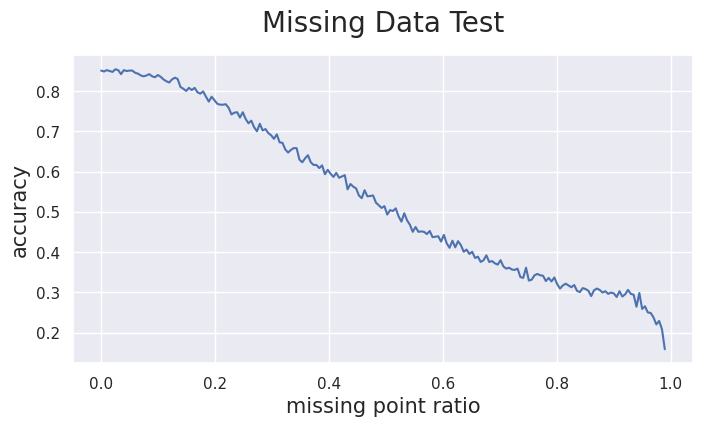

In [ ]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [ ]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
62.359375


Train loss: 1.656097412109375: : 62it [00:27,  2.21it/s]
29it [00:02, 10.50it/s]


epoch:  1 / 50
time: 30.77 seconds
train-loss: 1.99, train-acc-object: 30.29%, train-acc-pose: 18.67%
valid-loss: 1.88, valid-acc-object: 36.01%, train-acc-pose: 32.16%



Train loss: 1.2963804006576538: : 62it [00:27,  2.23it/s]
29it [00:02, 10.69it/s]


epoch:  2 / 50
time: 30.56 seconds
train-loss: 1.35, train-acc-object: 53.76%, train-acc-pose: 41.15%
valid-loss: 1.58, valid-acc-object: 49.78%, train-acc-pose: 46.15%



Train loss: 0.9878383278846741: : 62it [00:30,  2.04it/s]
29it [00:03,  9.34it/s]


epoch:  3 / 50
time: 33.54 seconds
train-loss: 1.08, train-acc-object: 63.96%, train-acc-pose: 51.11%
valid-loss: 1.40, valid-acc-object: 52.31%, train-acc-pose: 55.18%



Train loss: 0.772704541683197: : 62it [00:27,  2.23it/s]
29it [00:04,  6.96it/s]


epoch:  4 / 50
time: 31.99 seconds
train-loss: 0.91, train-acc-object: 69.30%, train-acc-pose: 59.58%
valid-loss: 1.18, valid-acc-object: 68.83%, train-acc-pose: 60.57%



Train loss: 0.8488622307777405: : 62it [00:27,  2.22it/s]
29it [00:03,  9.35it/s]


epoch:  5 / 50
time: 31.05 seconds
train-loss: 0.77, train-acc-object: 73.89%, train-acc-pose: 66.56%
valid-loss: 1.15, valid-acc-object: 66.19%, train-acc-pose: 62.67%



Train loss: 0.5480551719665527: : 62it [00:28,  2.21it/s]
29it [00:02, 10.60it/s]


epoch:  6 / 50
time: 30.78 seconds
train-loss: 0.64, train-acc-object: 79.51%, train-acc-pose: 70.54%
valid-loss: 0.97, valid-acc-object: 73.46%, train-acc-pose: 65.20%



Train loss: 0.536734402179718: : 62it [00:27,  2.22it/s]
29it [00:02, 10.70it/s]


epoch:  7 / 50
time: 30.62 seconds
train-loss: 0.59, train-acc-object: 80.12%, train-acc-pose: 73.36%
valid-loss: 0.95, valid-acc-object: 72.47%, train-acc-pose: 67.29%



Train loss: 0.7104571461677551: : 62it [00:28,  2.21it/s]
29it [00:02, 10.59it/s]


epoch:  8 / 50
time: 30.79 seconds
train-loss: 0.56, train-acc-object: 82.06%, train-acc-pose: 74.34%
valid-loss: 0.85, valid-acc-object: 76.76%, train-acc-pose: 66.30%



Train loss: 0.6217551231384277: : 62it [00:27,  2.22it/s]
29it [00:02, 10.50it/s]


epoch:  9 / 50
time: 30.69 seconds
train-loss: 0.51, train-acc-object: 83.32%, train-acc-pose: 74.62%
valid-loss: 0.82, valid-acc-object: 76.54%, train-acc-pose: 69.82%



Train loss: 0.33230260014533997: : 62it [00:28,  2.21it/s]
29it [00:03,  8.02it/s]


epoch: 10 / 50
time: 31.65 seconds
train-loss: 0.48, train-acc-object: 83.62%, train-acc-pose: 76.56%
valid-loss: 0.79, valid-acc-object: 78.08%, train-acc-pose: 69.71%



Train loss: 0.4483209252357483: : 62it [00:27,  2.22it/s]
29it [00:03,  7.65it/s]


epoch: 11 / 50
time: 31.70 seconds
train-loss: 0.43, train-acc-object: 86.27%, train-acc-pose: 78.50%
valid-loss: 0.77, valid-acc-object: 78.41%, train-acc-pose: 69.38%



Train loss: 0.6071332693099976: : 62it [00:27,  2.22it/s]
29it [00:02, 10.65it/s]


epoch: 12 / 50
time: 30.63 seconds
train-loss: 0.41, train-acc-object: 87.17%, train-acc-pose: 78.60%
valid-loss: 0.72, valid-acc-object: 80.18%, train-acc-pose: 70.48%



Train loss: 0.2875152826309204: : 62it [00:27,  2.23it/s]
29it [00:02, 10.74it/s]


epoch: 13 / 50
time: 30.53 seconds
train-loss: 0.40, train-acc-object: 87.45%, train-acc-pose: 79.56%
valid-loss: 0.73, valid-acc-object: 78.96%, train-acc-pose: 70.81%



Train loss: 0.28970879316329956: : 62it [00:28,  2.14it/s]
29it [00:02, 10.71it/s]


epoch: 14 / 50
time: 31.68 seconds
train-loss: 0.39, train-acc-object: 88.33%, train-acc-pose: 79.91%
valid-loss: 0.69, valid-acc-object: 80.29%, train-acc-pose: 72.03%



Train loss: 0.37611275911331177: : 62it [00:27,  2.22it/s]
29it [00:02, 10.87it/s]


epoch: 15 / 50
time: 30.58 seconds
train-loss: 0.38, train-acc-object: 88.23%, train-acc-pose: 80.19%
valid-loss: 0.68, valid-acc-object: 80.62%, train-acc-pose: 71.48%



Train loss: 0.37928497791290283: : 62it [00:28,  2.21it/s]
29it [00:02, 10.54it/s]


epoch: 16 / 50
time: 30.82 seconds
train-loss: 0.35, train-acc-object: 89.49%, train-acc-pose: 81.05%
valid-loss: 0.67, valid-acc-object: 80.40%, train-acc-pose: 72.25%



Train loss: 0.2902359068393707: : 62it [00:27,  2.23it/s]
29it [00:03,  9.18it/s]


epoch: 17 / 50
time: 30.93 seconds
train-loss: 0.34, train-acc-object: 89.94%, train-acc-pose: 81.73%
valid-loss: 0.66, valid-acc-object: 80.84%, train-acc-pose: 73.57%



Train loss: 0.46024230122566223: : 62it [00:27,  2.23it/s]
29it [00:04,  6.97it/s]


epoch: 18 / 50
time: 31.99 seconds
train-loss: 0.33, train-acc-object: 90.65%, train-acc-pose: 81.40%
valid-loss: 0.64, valid-acc-object: 80.73%, train-acc-pose: 72.58%



Train loss: 0.21524934470653534: : 62it [00:27,  2.22it/s]
29it [00:03,  9.41it/s]


epoch: 19 / 50
time: 30.97 seconds
train-loss: 0.32, train-acc-object: 90.42%, train-acc-pose: 82.16%
valid-loss: 0.64, valid-acc-object: 82.16%, train-acc-pose: 73.68%



Train loss: 0.3427659273147583: : 62it [00:28,  2.20it/s]
29it [00:02, 10.49it/s]


epoch: 20 / 50
time: 30.92 seconds
train-loss: 0.32, train-acc-object: 90.17%, train-acc-pose: 82.31%
valid-loss: 0.65, valid-acc-object: 81.72%, train-acc-pose: 72.91%



Train loss: 0.33679503202438354: : 62it [00:28,  2.21it/s]
29it [00:02, 10.48it/s]


epoch: 21 / 50
time: 30.88 seconds
train-loss: 0.30, train-acc-object: 90.93%, train-acc-pose: 83.29%
valid-loss: 0.62, valid-acc-object: 82.05%, train-acc-pose: 73.24%



Train loss: 0.32633230090141296: : 62it [00:28,  2.21it/s]
29it [00:02, 10.69it/s]


epoch: 22 / 50
time: 30.79 seconds
train-loss: 0.30, train-acc-object: 91.78%, train-acc-pose: 82.84%
valid-loss: 0.62, valid-acc-object: 82.60%, train-acc-pose: 72.91%



Train loss: 0.3127632737159729: : 62it [00:28,  2.21it/s]
29it [00:03,  9.51it/s]


epoch: 23 / 50
time: 31.08 seconds
train-loss: 0.29, train-acc-object: 91.81%, train-acc-pose: 83.57%
valid-loss: 0.61, valid-acc-object: 81.61%, train-acc-pose: 73.90%



Train loss: 0.3559810519218445: : 62it [00:28,  2.19it/s]
29it [00:04,  6.20it/s]


epoch: 24 / 50
time: 33.02 seconds
train-loss: 0.28, train-acc-object: 91.63%, train-acc-pose: 83.64%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 74.23%



Train loss: 0.15367507934570312: : 62it [00:27,  2.23it/s]
29it [00:03,  8.38it/s]


epoch: 25 / 50
time: 31.34 seconds
train-loss: 0.28, train-acc-object: 91.91%, train-acc-pose: 83.47%
valid-loss: 0.61, valid-acc-object: 82.49%, train-acc-pose: 74.23%



Train loss: 0.2262253612279892: : 62it [00:28,  2.21it/s]
29it [00:02, 10.53it/s]


epoch: 26 / 50
time: 30.82 seconds
train-loss: 0.27, train-acc-object: 91.94%, train-acc-pose: 83.47%
valid-loss: 0.60, valid-acc-object: 82.60%, train-acc-pose: 74.12%



Train loss: 0.19031444191932678: : 62it [00:27,  2.22it/s]
29it [00:02, 10.69it/s]


epoch: 27 / 50
time: 30.71 seconds
train-loss: 0.27, train-acc-object: 92.16%, train-acc-pose: 84.02%
valid-loss: 0.60, valid-acc-object: 82.38%, train-acc-pose: 74.34%



Train loss: 0.19641846418380737: : 62it [00:28,  2.20it/s]
29it [00:02, 10.53it/s]


epoch: 28 / 50
time: 30.99 seconds
train-loss: 0.27, train-acc-object: 92.14%, train-acc-pose: 84.05%
valid-loss: 0.60, valid-acc-object: 81.94%, train-acc-pose: 73.68%



Train loss: 0.21825647354125977: : 62it [00:28,  2.20it/s]
29it [00:02, 10.44it/s]


epoch: 29 / 50
time: 30.97 seconds
train-loss: 0.26, train-acc-object: 92.87%, train-acc-pose: 83.90%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 74.12%



Train loss: 0.3140861988067627: : 62it [00:28,  2.20it/s]
29it [00:03,  7.52it/s]


epoch: 30 / 50
time: 32.03 seconds
train-loss: 0.27, train-acc-object: 92.52%, train-acc-pose: 84.35%
valid-loss: 0.60, valid-acc-object: 83.37%, train-acc-pose: 74.67%



Train loss: 0.19618254899978638: : 62it [00:27,  2.22it/s]
29it [00:03,  8.31it/s]


epoch: 31 / 50
time: 31.46 seconds
train-loss: 0.26, train-acc-object: 92.49%, train-acc-pose: 84.32%
valid-loss: 0.59, valid-acc-object: 82.60%, train-acc-pose: 75.11%



Train loss: 0.3390346169471741: : 62it [00:28,  2.19it/s]
29it [00:02, 10.64it/s]


epoch: 32 / 50
time: 31.01 seconds
train-loss: 0.27, train-acc-object: 92.41%, train-acc-pose: 84.20%
valid-loss: 0.59, valid-acc-object: 82.82%, train-acc-pose: 74.56%



Train loss: 0.21446040272712708: : 62it [00:28,  2.21it/s]
29it [00:02, 10.56it/s]


epoch: 33 / 50
time: 30.80 seconds
train-loss: 0.26, train-acc-object: 92.82%, train-acc-pose: 83.57%
valid-loss: 0.59, valid-acc-object: 82.05%, train-acc-pose: 75.11%



Train loss: 0.2360449731349945: : 62it [00:28,  2.21it/s]
29it [00:02, 10.47it/s]


epoch: 34 / 50
time: 30.79 seconds
train-loss: 0.26, train-acc-object: 92.67%, train-acc-pose: 84.35%
valid-loss: 0.59, valid-acc-object: 82.38%, train-acc-pose: 74.78%



Train loss: 0.37283962965011597: : 62it [00:28,  2.15it/s]
29it [00:03,  9.66it/s]


epoch: 35 / 50
time: 31.90 seconds
train-loss: 0.26, train-acc-object: 92.29%, train-acc-pose: 84.38%
valid-loss: 0.59, valid-acc-object: 82.27%, train-acc-pose: 74.56%



Train loss: 0.2373879849910736: : 62it [00:28,  2.21it/s]
29it [00:04,  6.85it/s]


epoch: 36 / 50
time: 32.31 seconds
train-loss: 0.26, train-acc-object: 92.74%, train-acc-pose: 85.01%
valid-loss: 0.59, valid-acc-object: 82.38%, train-acc-pose: 75.11%



Train loss: 0.2614934742450714: : 62it [00:27,  2.22it/s]
29it [00:03,  9.29it/s]


epoch: 37 / 50
time: 31.06 seconds
train-loss: 0.25, train-acc-object: 92.59%, train-acc-pose: 85.33%
valid-loss: 0.59, valid-acc-object: 82.49%, train-acc-pose: 74.89%



Train loss: 0.2569817304611206: : 62it [00:28,  2.21it/s]
29it [00:02, 10.47it/s]


epoch: 38 / 50
time: 30.83 seconds
train-loss: 0.26, train-acc-object: 92.79%, train-acc-pose: 84.75%
valid-loss: 0.59, valid-acc-object: 82.60%, train-acc-pose: 74.67%



Train loss: 0.20196574926376343: : 62it [00:28,  2.21it/s]
29it [00:02, 10.47it/s]


epoch: 39 / 50
time: 30.83 seconds
train-loss: 0.26, train-acc-object: 92.34%, train-acc-pose: 85.06%
valid-loss: 0.59, valid-acc-object: 82.60%, train-acc-pose: 74.89%



Train loss: 0.30116090178489685: : 62it [00:28,  2.21it/s]
29it [00:02, 10.57it/s]


epoch: 40 / 50
time: 30.79 seconds
train-loss: 0.26, train-acc-object: 92.92%, train-acc-pose: 83.97%
valid-loss: 0.59, valid-acc-object: 82.93%, train-acc-pose: 74.78%



Train loss: 0.23124906420707703: : 7it [00:03,  2.06it/s]


KeyboardInterrupt: ignored

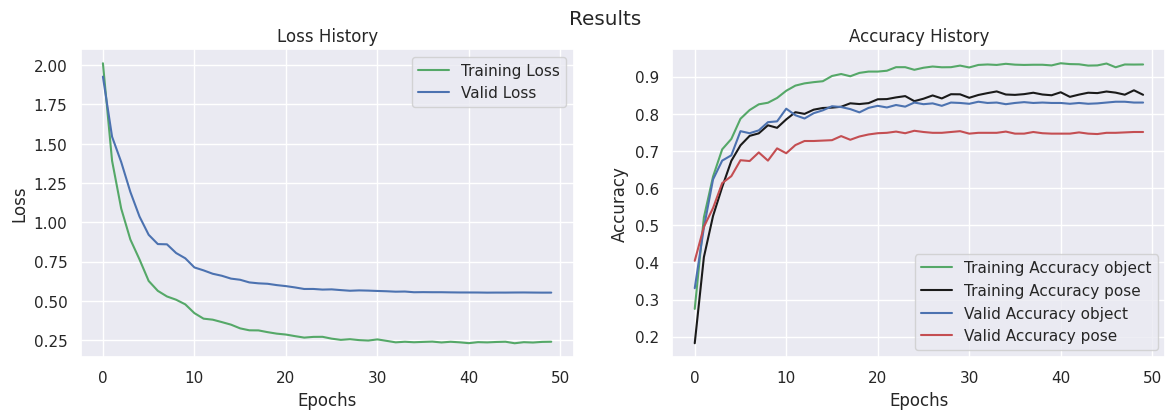

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 32
with a validation loss of: 0.56189954 and a validation accuracy of: 83.25991034507751


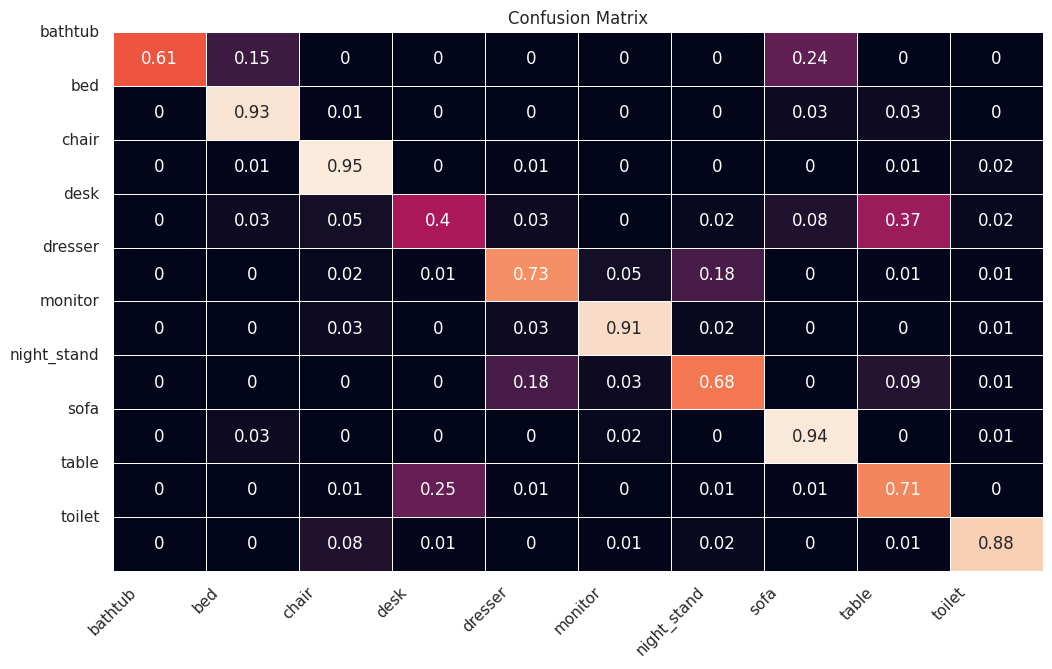

In [ ]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 23
with a validation loss of: 0.46264336 and a validation accuracy of: 84.69163179397583


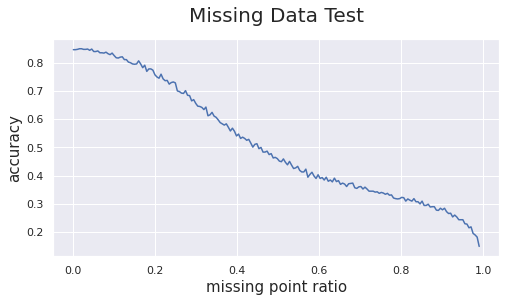

In [ ]:
trainer3.missing_data_test()

# VoxNet model comparison

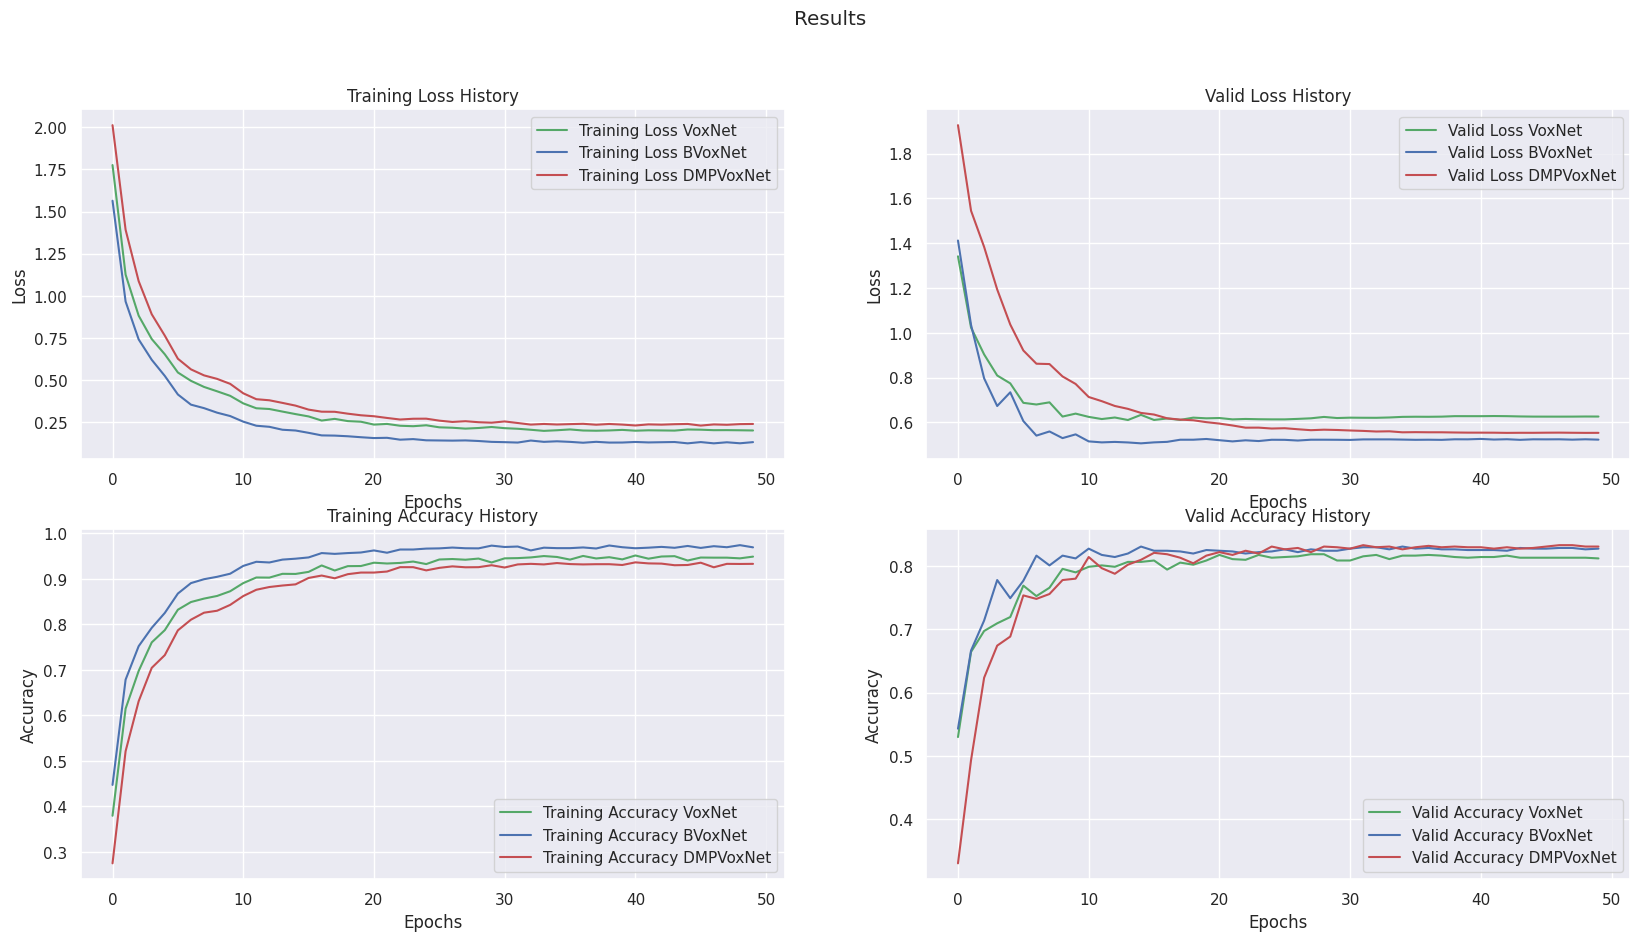

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# Data Augmentation



In [ ]:
import os
import math
import random

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)[:100]):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        rot = random.choice(ROTATIONS)
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if rot == '0':
            mesh = mesh
            rotat = 0
          elif rot == '45':
            mesh.rotate(r45)
            rotat = 1
          elif rot == '90':
            mesh.rotate(r90)
            rotat = 2
          elif rot == '135':
            mesh.rotate(r135) 
            rotat = 3 
          elif rot == '180':
            mesh.rotate(r180)
            rotat = 4
          elif rot == '225':
            mesh.rotate(r225)
            rotat = 5
          elif rot == '270':
            mesh.rotate(r270)
            rotat = 6
          else:
            mesh.rotate(r315)
            rotat = 7
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:04<00:00, 20.61it/s]


In [ ]:
class VoxelDataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset_a(train=True)
      self.test_ds = VoxelDataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet_a":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=10)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=8)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=8)
      self.alpha = 2/3
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}    

trainer4 = VoxNet_Trainer(training_hyperparameters)
trainer4.train()

model DMPVoxNet was choosen
125.0


Train loss: 1.3574467897415161: : 125it [00:58,  2.13it/s]
29it [00:04,  6.50it/s]


epoch:  1 / 50
time: 63.25 seconds
train-loss: 1.86, train-acc-object: 26.45%, train-acc-pose: 26.50%
valid-loss: 1.58, valid-acc-object: 54.30%, train-acc-pose: 47.25%



Train loss: 1.0221744775772095: : 125it [00:59,  2.10it/s]
29it [00:04,  6.94it/s]


epoch:  2 / 50
time: 63.73 seconds
train-loss: 1.16, train-acc-object: 57.24%, train-acc-pose: 46.90%
valid-loss: 1.21, valid-acc-object: 70.70%, train-acc-pose: 59.14%



Train loss: 0.719111442565918: : 125it [01:02,  2.02it/s]
29it [00:04,  6.55it/s]


epoch:  3 / 50
time: 66.48 seconds
train-loss: 0.89, train-acc-object: 70.39%, train-acc-pose: 55.60%
valid-loss: 0.97, valid-acc-object: 75.55%, train-acc-pose: 64.76%



Train loss: 0.6538016200065613: : 125it [01:02,  2.01it/s]
29it [00:04,  7.11it/s]


epoch:  4 / 50
time: 66.17 seconds
train-loss: 0.73, train-acc-object: 76.23%, train-acc-pose: 60.54%
valid-loss: 0.89, valid-acc-object: 77.86%, train-acc-pose: 67.51%



Train loss: 0.4954513907432556: : 125it [01:02,  2.00it/s]
29it [00:03,  8.24it/s]


epoch:  5 / 50
time: 65.97 seconds
train-loss: 0.64, train-acc-object: 79.68%, train-acc-pose: 63.06%
valid-loss: 0.79, valid-acc-object: 76.98%, train-acc-pose: 69.49%



Train loss: 0.46963149309158325: : 125it [01:02,  2.00it/s]
29it [00:03,  8.38it/s]


epoch:  6 / 50
time: 65.84 seconds
train-loss: 0.52, train-acc-object: 84.91%, train-acc-pose: 67.61%
valid-loss: 0.70, valid-acc-object: 79.63%, train-acc-pose: 70.93%



Train loss: 0.504136323928833: : 125it [01:02,  2.01it/s]
29it [00:03,  8.14it/s]


epoch:  7 / 50
time: 65.84 seconds
train-loss: 0.48, train-acc-object: 85.58%, train-acc-pose: 68.00%
valid-loss: 0.70, valid-acc-object: 77.31%, train-acc-pose: 73.02%



Train loss: 0.34376657009124756: : 125it [01:02,  2.01it/s]
29it [00:03,  8.23it/s]


epoch:  8 / 50
time: 65.61 seconds
train-loss: 0.45, train-acc-object: 86.91%, train-acc-pose: 68.69%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 73.24%



Train loss: 0.2779015004634857: : 125it [01:01,  2.02it/s]
29it [00:03,  8.32it/s]


epoch:  9 / 50
time: 65.35 seconds
train-loss: 0.42, train-acc-object: 88.41%, train-acc-pose: 69.74%
valid-loss: 0.59, valid-acc-object: 80.73%, train-acc-pose: 74.56%



Train loss: 0.37679535150527954: : 125it [01:01,  2.03it/s]
29it [00:03,  8.32it/s]


epoch: 10 / 50
time: 64.98 seconds
train-loss: 0.40, train-acc-object: 89.39%, train-acc-pose: 70.28%
valid-loss: 0.61, valid-acc-object: 80.29%, train-acc-pose: 76.98%



Train loss: 0.40213507413864136: : 125it [01:01,  2.04it/s]
29it [00:03,  8.30it/s]


epoch: 11 / 50
time: 64.92 seconds
train-loss: 0.36, train-acc-object: 90.55%, train-acc-pose: 71.47%
valid-loss: 0.53, valid-acc-object: 84.25%, train-acc-pose: 74.78%



Train loss: 0.3248613476753235: : 125it [01:01,  2.04it/s]
29it [00:03,  8.33it/s]


epoch: 12 / 50
time: 64.88 seconds
train-loss: 0.34, train-acc-object: 91.25%, train-acc-pose: 72.18%
valid-loss: 0.51, valid-acc-object: 84.58%, train-acc-pose: 77.09%



Train loss: 0.3414892256259918: : 125it [01:01,  2.03it/s]
29it [00:03,  8.57it/s]


epoch: 13 / 50
time: 64.83 seconds
train-loss: 0.32, train-acc-object: 92.51%, train-acc-pose: 71.89%
valid-loss: 0.51, valid-acc-object: 83.26%, train-acc-pose: 76.43%



Train loss: 0.24910089373588562: : 125it [01:01,  2.02it/s]
29it [00:03,  8.18it/s]


epoch: 14 / 50
time: 65.42 seconds
train-loss: 0.31, train-acc-object: 92.62%, train-acc-pose: 72.43%
valid-loss: 0.51, valid-acc-object: 85.24%, train-acc-pose: 76.43%



Train loss: 0.30598825216293335: : 125it [01:02,  2.01it/s]
29it [00:03,  8.25it/s]


epoch: 15 / 50
time: 65.76 seconds
train-loss: 0.30, train-acc-object: 93.23%, train-acc-pose: 72.70%
valid-loss: 0.51, valid-acc-object: 83.04%, train-acc-pose: 77.75%



Train loss: 0.2849877178668976: : 125it [01:02,  2.01it/s]
29it [00:03,  8.36it/s]


epoch: 16 / 50
time: 65.81 seconds
train-loss: 0.28, train-acc-object: 94.16%, train-acc-pose: 73.99%
valid-loss: 0.49, valid-acc-object: 82.93%, train-acc-pose: 77.86%



Train loss: 0.2487739473581314: : 125it [01:02,  2.01it/s]
29it [00:03,  7.65it/s]


epoch: 17 / 50
time: 66.13 seconds
train-loss: 0.27, train-acc-object: 94.36%, train-acc-pose: 74.25%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 78.08%



Train loss: 0.2719835042953491: : 125it [01:02,  2.01it/s]
29it [00:04,  7.06it/s]


epoch: 18 / 50
time: 66.25 seconds
train-loss: 0.27, train-acc-object: 94.36%, train-acc-pose: 74.54%
valid-loss: 0.48, valid-acc-object: 85.90%, train-acc-pose: 77.42%



Train loss: 0.3124074339866638: : 125it [01:01,  2.02it/s]
29it [00:04,  6.66it/s]


epoch: 19 / 50
time: 66.18 seconds
train-loss: 0.27, train-acc-object: 94.63%, train-acc-pose: 74.11%
valid-loss: 0.49, valid-acc-object: 84.14%, train-acc-pose: 77.31%



Train loss: 0.2596905827522278: : 125it [01:01,  2.03it/s]
29it [00:04,  6.72it/s]


epoch: 20 / 50
time: 66.06 seconds
train-loss: 0.27, train-acc-object: 94.14%, train-acc-pose: 74.18%
valid-loss: 0.47, valid-acc-object: 84.80%, train-acc-pose: 78.41%



Train loss: 0.20083574950695038: : 125it [01:01,  2.03it/s]
29it [00:03,  7.30it/s]


epoch: 21 / 50
time: 65.63 seconds
train-loss: 0.25, train-acc-object: 94.80%, train-acc-pose: 74.61%
valid-loss: 0.47, valid-acc-object: 84.14%, train-acc-pose: 77.86%



Train loss: 0.20757508277893066: : 125it [01:01,  2.03it/s]
29it [00:03,  7.69it/s]


epoch: 22 / 50
time: 65.42 seconds
train-loss: 0.25, train-acc-object: 95.29%, train-acc-pose: 75.19%
valid-loss: 0.47, valid-acc-object: 84.03%, train-acc-pose: 78.41%



Train loss: 0.1685921847820282: : 125it [01:02,  2.01it/s]
29it [00:03,  8.41it/s]


epoch: 23 / 50
time: 65.77 seconds
train-loss: 0.25, train-acc-object: 95.24%, train-acc-pose: 74.64%
valid-loss: 0.46, valid-acc-object: 85.57%, train-acc-pose: 78.85%



Train loss: 0.20869366824626923: : 125it [01:02,  2.01it/s]
29it [00:03,  8.45it/s]


epoch: 24 / 50
time: 65.70 seconds
train-loss: 0.24, train-acc-object: 95.31%, train-acc-pose: 75.42%
valid-loss: 0.46, valid-acc-object: 84.80%, train-acc-pose: 78.52%



Train loss: 0.29581665992736816: : 125it [01:02,  2.01it/s]
29it [00:03,  8.25it/s]


epoch: 25 / 50
time: 65.59 seconds
train-loss: 0.24, train-acc-object: 95.74%, train-acc-pose: 75.39%
valid-loss: 0.46, valid-acc-object: 84.36%, train-acc-pose: 77.20%



Train loss: 0.25914058089256287: : 125it [01:01,  2.03it/s]
29it [00:03,  8.48it/s]


epoch: 26 / 50
time: 64.90 seconds
train-loss: 0.24, train-acc-object: 95.89%, train-acc-pose: 75.49%
valid-loss: 0.46, valid-acc-object: 84.91%, train-acc-pose: 78.08%



Train loss: 0.2411459982395172: : 125it [01:01,  2.04it/s]
29it [00:03,  8.80it/s]


epoch: 27 / 50
time: 64.61 seconds
train-loss: 0.24, train-acc-object: 95.66%, train-acc-pose: 75.14%
valid-loss: 0.45, valid-acc-object: 85.90%, train-acc-pose: 79.52%



Train loss: 0.21649575233459473: : 125it [01:01,  2.03it/s]
29it [00:03,  8.43it/s]


epoch: 28 / 50
time: 64.91 seconds
train-loss: 0.23, train-acc-object: 95.80%, train-acc-pose: 75.79%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 79.30%



Train loss: 0.15478384494781494: : 125it [01:01,  2.04it/s]
29it [00:03,  8.67it/s]


epoch: 29 / 50
time: 64.69 seconds
train-loss: 0.23, train-acc-object: 95.90%, train-acc-pose: 76.06%
valid-loss: 0.46, valid-acc-object: 84.36%, train-acc-pose: 79.52%



Train loss: 0.2467726767063141: : 125it [01:01,  2.03it/s]
29it [00:03,  8.67it/s]


epoch: 30 / 50
time: 64.81 seconds
train-loss: 0.23, train-acc-object: 95.95%, train-acc-pose: 75.69%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 79.63%



Train loss: 0.2799041271209717: : 125it [01:01,  2.05it/s]
29it [00:03,  8.68it/s]


epoch: 31 / 50
time: 64.40 seconds
train-loss: 0.23, train-acc-object: 96.03%, train-acc-pose: 75.82%
valid-loss: 0.46, valid-acc-object: 84.91%, train-acc-pose: 78.85%



Train loss: 0.17730355262756348: : 125it [01:01,  2.05it/s]
29it [00:03,  8.93it/s]


epoch: 32 / 50
time: 64.35 seconds
train-loss: 0.23, train-acc-object: 96.17%, train-acc-pose: 76.07%
valid-loss: 0.45, valid-acc-object: 85.79%, train-acc-pose: 79.07%



Train loss: 0.14933131635189056: : 125it [01:00,  2.06it/s]
29it [00:03,  8.15it/s]


epoch: 33 / 50
time: 64.31 seconds
train-loss: 0.22, train-acc-object: 96.10%, train-acc-pose: 76.11%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.52%



Train loss: 0.29360103607177734: : 125it [01:00,  2.07it/s]
29it [00:03,  7.51it/s]


epoch: 34 / 50
time: 64.36 seconds
train-loss: 0.23, train-acc-object: 96.14%, train-acc-pose: 76.15%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 79.74%



Train loss: 0.16217800974845886: : 125it [01:00,  2.08it/s]
29it [00:04,  6.97it/s]


epoch: 35 / 50
time: 64.24 seconds
train-loss: 0.23, train-acc-object: 96.07%, train-acc-pose: 75.77%
valid-loss: 0.45, valid-acc-object: 85.79%, train-acc-pose: 78.85%



Train loss: 0.2036052793264389: : 125it [00:59,  2.09it/s]
29it [00:04,  6.84it/s]


epoch: 36 / 50
time: 63.95 seconds
train-loss: 0.22, train-acc-object: 96.13%, train-acc-pose: 76.56%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.28186070919036865: : 125it [00:59,  2.10it/s]
29it [00:03,  8.09it/s]


epoch: 37 / 50
time: 63.09 seconds
train-loss: 0.23, train-acc-object: 96.20%, train-acc-pose: 76.05%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 78.85%



Train loss: 0.2854948341846466: : 125it [00:59,  2.12it/s]
29it [00:03,  9.63it/s]


epoch: 38 / 50
time: 62.03 seconds
train-loss: 0.22, train-acc-object: 96.40%, train-acc-pose: 76.16%
valid-loss: 0.45, valid-acc-object: 85.24%, train-acc-pose: 79.07%



Train loss: 0.24025346338748932: : 125it [00:59,  2.11it/s]
29it [00:03,  9.28it/s]


epoch: 39 / 50
time: 62.30 seconds
train-loss: 0.22, train-acc-object: 95.99%, train-acc-pose: 76.56%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 78.85%



Train loss: 0.26266056299209595: : 125it [00:59,  2.11it/s]
29it [00:03,  9.48it/s]


epoch: 40 / 50
time: 62.23 seconds
train-loss: 0.22, train-acc-object: 96.38%, train-acc-pose: 76.70%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 78.85%



Train loss: 0.16546449065208435: : 125it [00:58,  2.14it/s]
29it [00:04,  7.04it/s]


epoch: 41 / 50
time: 62.42 seconds
train-loss: 0.22, train-acc-object: 95.85%, train-acc-pose: 76.44%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 78.85%



Train loss: 0.15381282567977905: : 125it [00:58,  2.14it/s]
29it [00:03,  9.11it/s]


epoch: 42 / 50
time: 61.57 seconds
train-loss: 0.22, train-acc-object: 96.34%, train-acc-pose: 76.15%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 78.85%



Train loss: 0.23699913918972015: : 125it [00:58,  2.14it/s]
29it [00:02,  9.81it/s]


epoch: 43 / 50
time: 61.48 seconds
train-loss: 0.22, train-acc-object: 96.31%, train-acc-pose: 75.45%
valid-loss: 0.45, valid-acc-object: 85.24%, train-acc-pose: 79.07%



Train loss: 0.2570289075374603: : 125it [00:58,  2.14it/s]
29it [00:02,  9.90it/s]


epoch: 44 / 50
time: 61.34 seconds
train-loss: 0.22, train-acc-object: 96.34%, train-acc-pose: 76.70%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.19%



Train loss: 0.13829568028450012: : 125it [00:57,  2.16it/s]
29it [00:03,  7.35it/s]


epoch: 45 / 50
time: 61.81 seconds
train-loss: 0.22, train-acc-object: 96.57%, train-acc-pose: 76.63%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.41%



Train loss: 0.2353093922138214: : 125it [00:57,  2.17it/s]
29it [00:02,  9.92it/s]


epoch: 46 / 50
time: 60.61 seconds
train-loss: 0.22, train-acc-object: 96.61%, train-acc-pose: 76.41%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.30%



Train loss: 0.17481622099876404: : 125it [00:58,  2.14it/s]
29it [00:02,  9.97it/s]


epoch: 47 / 50
time: 61.22 seconds
train-loss: 0.22, train-acc-object: 96.26%, train-acc-pose: 76.32%
valid-loss: 0.45, valid-acc-object: 85.57%, train-acc-pose: 79.63%



Train loss: 0.21160930395126343: : 125it [00:58,  2.14it/s]
29it [00:03,  9.11it/s]


epoch: 48 / 50
time: 61.56 seconds
train-loss: 0.22, train-acc-object: 96.39%, train-acc-pose: 76.26%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.41%



Train loss: 0.22710874676704407: : 125it [00:57,  2.17it/s]
29it [00:03,  8.33it/s]


epoch: 49 / 50
time: 61.14 seconds
train-loss: 0.22, train-acc-object: 96.11%, train-acc-pose: 76.13%
valid-loss: 0.45, valid-acc-object: 85.57%, train-acc-pose: 79.96%



Train loss: 0.22088561952114105: : 125it [00:58,  2.15it/s]
29it [00:02,  9.93it/s]

epoch: 50 / 50
time: 61.10 seconds
train-loss: 0.22, train-acc-object: 96.45%, train-acc-pose: 76.80%
valid-loss: 0.45, valid-acc-object: 85.46%, train-acc-pose: 79.52%



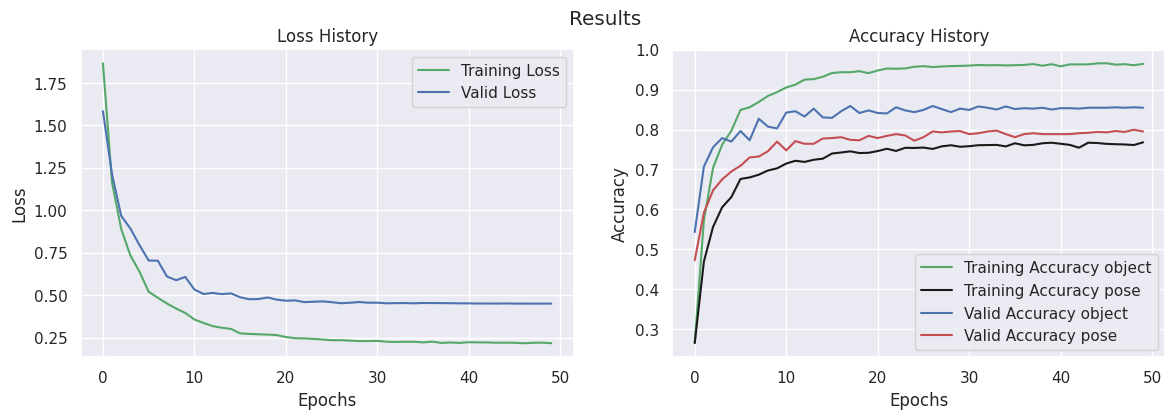

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

best model was trained at epoch: 18
with a validation loss of: 0.47731754 and a validation accuracy of: 85.90308427810669


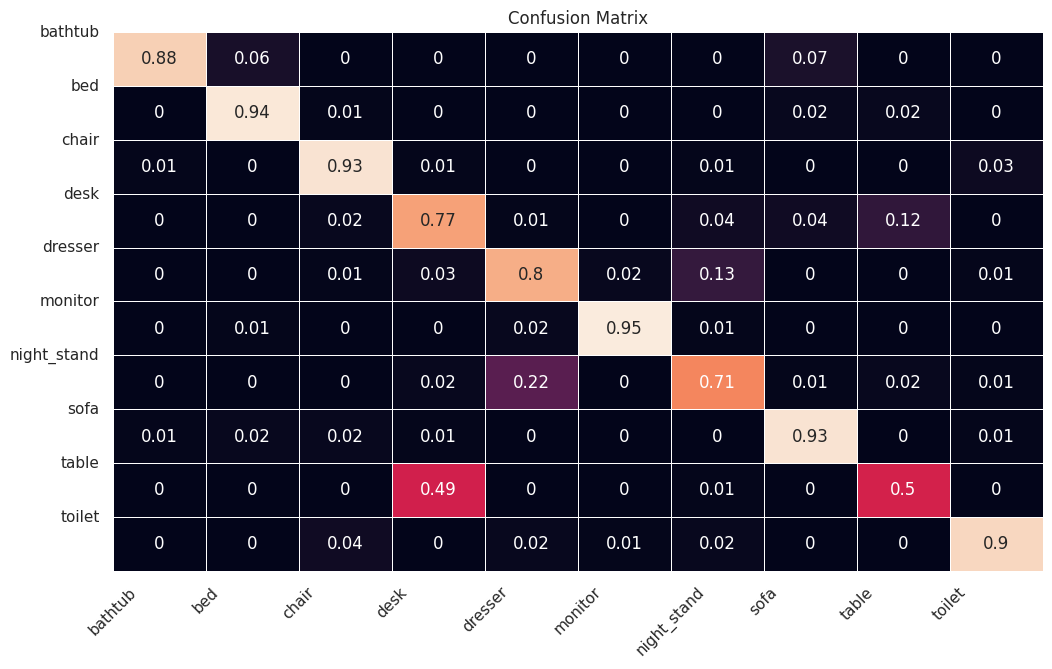

In [ ]:
trainer4.generateConfusionMatrix()

In [ ]:
trainer4.test_on_missing_data()

KeyboardInterrupt: ignored

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet_a'
}    

trainer5 = VoxNet_Trainer(training_hyperparameters)
trainer5.train()

model DMPVoxNet was choosen
125.0


Train loss: 1.2348742485046387: : 125it [00:59,  2.12it/s]
29it [00:02,  9.99it/s]


epoch:  1 / 50
time: 61.99 seconds
train-loss: 1.85, train-acc-object: 29.14%, train-acc-pose: 26.52%
valid-loss: 1.55, valid-acc-object: 54.30%, train-acc-pose: 48.24%



Train loss: 0.8723815679550171: : 125it [00:58,  2.15it/s]
29it [00:02,  9.80it/s]


epoch:  2 / 50
time: 61.12 seconds
train-loss: 1.16, train-acc-object: 58.21%, train-acc-pose: 47.21%
valid-loss: 1.20, valid-acc-object: 72.91%, train-acc-pose: 60.35%



Train loss: 0.8900160193443298: : 125it [00:57,  2.16it/s]
29it [00:04,  7.18it/s]


epoch:  3 / 50
time: 61.91 seconds
train-loss: 0.89, train-acc-object: 71.28%, train-acc-pose: 54.89%
valid-loss: 1.07, valid-acc-object: 74.67%, train-acc-pose: 61.56%



Train loss: 0.6169264912605286: : 125it [00:57,  2.16it/s]
29it [00:02,  9.95it/s]


epoch:  4 / 50
time: 60.90 seconds
train-loss: 0.74, train-acc-object: 76.41%, train-acc-pose: 58.42%
valid-loss: 0.84, valid-acc-object: 75.99%, train-acc-pose: 68.28%



Train loss: 0.6791324615478516: : 125it [00:58,  2.14it/s]
29it [00:03,  9.60it/s]


epoch:  5 / 50
time: 61.36 seconds
train-loss: 0.64, train-acc-object: 79.84%, train-acc-pose: 62.56%
valid-loss: 0.78, valid-acc-object: 82.49%, train-acc-pose: 68.50%



Train loss: 0.5281243920326233: : 125it [00:58,  2.14it/s]
29it [00:02,  9.90it/s]


epoch:  6 / 50
time: 61.39 seconds
train-loss: 0.50, train-acc-object: 85.21%, train-acc-pose: 66.53%
valid-loss: 0.69, valid-acc-object: 80.95%, train-acc-pose: 71.26%



Train loss: 0.41962867975234985: : 125it [00:57,  2.17it/s]
29it [00:04,  7.12it/s]


epoch:  7 / 50
time: 61.74 seconds
train-loss: 0.47, train-acc-object: 86.21%, train-acc-pose: 67.99%
valid-loss: 0.66, valid-acc-object: 82.05%, train-acc-pose: 73.13%



Train loss: 0.38497793674468994: : 125it [00:58,  2.15it/s]
29it [00:03,  9.60it/s]


epoch:  8 / 50
time: 61.07 seconds
train-loss: 0.43, train-acc-object: 88.10%, train-acc-pose: 68.60%
valid-loss: 0.63, valid-acc-object: 83.59%, train-acc-pose: 73.02%



Train loss: 0.6252914667129517: : 125it [00:58,  2.14it/s]
29it [00:03,  9.40it/s]


epoch:  9 / 50
time: 61.49 seconds
train-loss: 0.41, train-acc-object: 88.71%, train-acc-pose: 69.14%
valid-loss: 0.59, valid-acc-object: 81.94%, train-acc-pose: 73.90%



Train loss: 0.4255009889602661: : 125it [00:58,  2.15it/s]
29it [00:03,  8.42it/s]


epoch: 10 / 50
time: 61.48 seconds
train-loss: 0.39, train-acc-object: 88.81%, train-acc-pose: 69.71%
valid-loss: 0.57, valid-acc-object: 84.25%, train-acc-pose: 75.88%



Train loss: 0.304756224155426: : 125it [00:58,  2.15it/s]
29it [00:03,  7.87it/s]


epoch: 11 / 50
time: 61.80 seconds
train-loss: 0.34, train-acc-object: 91.61%, train-acc-pose: 71.71%
valid-loss: 0.54, valid-acc-object: 85.13%, train-acc-pose: 75.33%



Train loss: 0.2776283919811249: : 125it [00:58,  2.15it/s]
29it [00:02,  9.99it/s]


epoch: 12 / 50
time: 61.01 seconds
train-loss: 0.32, train-acc-object: 92.37%, train-acc-pose: 71.95%
valid-loss: 0.53, valid-acc-object: 83.59%, train-acc-pose: 75.33%



Train loss: 0.25552982091903687: : 125it [00:58,  2.14it/s]
29it [00:02,  9.79it/s]


epoch: 13 / 50
time: 61.29 seconds
train-loss: 0.32, train-acc-object: 92.62%, train-acc-pose: 71.82%
valid-loss: 0.52, valid-acc-object: 84.69%, train-acc-pose: 76.87%



Train loss: 0.2704808712005615: : 125it [00:57,  2.16it/s]
29it [00:03,  7.66it/s]


epoch: 14 / 50
time: 61.62 seconds
train-loss: 0.30, train-acc-object: 92.99%, train-acc-pose: 72.86%
valid-loss: 0.51, valid-acc-object: 83.70%, train-acc-pose: 76.43%



Train loss: 0.3286551833152771: : 125it [00:57,  2.17it/s]
29it [00:02,  9.87it/s]


epoch: 15 / 50
time: 60.51 seconds
train-loss: 0.30, train-acc-object: 93.42%, train-acc-pose: 72.75%
valid-loss: 0.49, valid-acc-object: 85.35%, train-acc-pose: 76.76%



Train loss: 0.321985125541687: : 125it [00:58,  2.14it/s]
29it [00:02, 10.09it/s]


epoch: 16 / 50
time: 61.19 seconds
train-loss: 0.28, train-acc-object: 94.27%, train-acc-pose: 74.54%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 77.86%



Train loss: 0.269656240940094: : 125it [00:58,  2.14it/s]
29it [00:02,  9.98it/s]


epoch: 17 / 50
time: 61.23 seconds
train-loss: 0.26, train-acc-object: 94.76%, train-acc-pose: 74.09%
valid-loss: 0.48, valid-acc-object: 83.70%, train-acc-pose: 76.76%



Train loss: 0.23373502492904663: : 125it [00:57,  2.16it/s]
29it [00:03,  7.57it/s]


epoch: 18 / 50
time: 61.66 seconds
train-loss: 0.26, train-acc-object: 95.21%, train-acc-pose: 74.05%
valid-loss: 0.47, valid-acc-object: 85.35%, train-acc-pose: 78.08%



Train loss: 0.19479909539222717: : 125it [00:58,  2.15it/s]
29it [00:02,  9.86it/s]


epoch: 19 / 50
time: 61.00 seconds
train-loss: 0.25, train-acc-object: 94.94%, train-acc-pose: 74.70%
valid-loss: 0.47, valid-acc-object: 84.69%, train-acc-pose: 77.64%



Train loss: 0.22890853881835938: : 125it [00:58,  2.15it/s]
29it [00:02, 10.09it/s]


epoch: 20 / 50
time: 60.95 seconds
train-loss: 0.25, train-acc-object: 95.39%, train-acc-pose: 74.37%
valid-loss: 0.47, valid-acc-object: 84.47%, train-acc-pose: 78.19%



Train loss: 0.27060890197753906: : 125it [00:57,  2.16it/s]
29it [00:03,  8.30it/s]


epoch: 21 / 50
time: 61.48 seconds
train-loss: 0.24, train-acc-object: 95.59%, train-acc-pose: 74.80%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.20%



Train loss: 0.27082791924476624: : 125it [00:57,  2.16it/s]
29it [00:03,  8.81it/s]


epoch: 22 / 50
time: 61.09 seconds
train-loss: 0.23, train-acc-object: 95.80%, train-acc-pose: 75.76%
valid-loss: 0.46, valid-acc-object: 85.02%, train-acc-pose: 77.75%



Train loss: 0.19452059268951416: : 125it [00:57,  2.16it/s]
29it [00:02, 10.13it/s]


epoch: 23 / 50
time: 60.72 seconds
train-loss: 0.23, train-acc-object: 95.92%, train-acc-pose: 75.30%
valid-loss: 0.46, valid-acc-object: 84.25%, train-acc-pose: 78.41%



Train loss: 0.19544292986392975: : 125it [00:58,  2.15it/s]
29it [00:02, 10.07it/s]


epoch: 24 / 50
time: 61.13 seconds
train-loss: 0.23, train-acc-object: 96.14%, train-acc-pose: 75.95%
valid-loss: 0.46, valid-acc-object: 84.91%, train-acc-pose: 77.86%



Train loss: 0.2406718134880066: : 125it [00:57,  2.17it/s]
29it [00:03,  7.39it/s]


epoch: 25 / 50
time: 61.63 seconds
train-loss: 0.23, train-acc-object: 95.95%, train-acc-pose: 75.55%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 78.08%



Train loss: 0.21247921884059906: : 125it [00:57,  2.18it/s]
29it [00:02, 10.08it/s]


epoch: 26 / 50
time: 60.30 seconds
train-loss: 0.22, train-acc-object: 96.35%, train-acc-pose: 76.59%
valid-loss: 0.46, valid-acc-object: 84.91%, train-acc-pose: 78.96%



Train loss: 0.19868454337120056: : 125it [00:58,  2.15it/s]
29it [00:02,  9.95it/s]


epoch: 27 / 50
time: 60.96 seconds
train-loss: 0.23, train-acc-object: 96.04%, train-acc-pose: 75.70%
valid-loss: 0.46, valid-acc-object: 84.58%, train-acc-pose: 77.20%



Train loss: 0.20535102486610413: : 125it [00:57,  2.17it/s]
29it [00:03,  8.34it/s]


epoch: 28 / 50
time: 61.18 seconds
train-loss: 0.22, train-acc-object: 96.51%, train-acc-pose: 76.65%
valid-loss: 0.45, valid-acc-object: 84.69%, train-acc-pose: 77.31%



Train loss: 0.19420593976974487: : 125it [00:57,  2.17it/s]
29it [00:03,  8.94it/s]


epoch: 29 / 50
time: 60.96 seconds
train-loss: 0.22, train-acc-object: 96.30%, train-acc-pose: 76.75%
valid-loss: 0.45, valid-acc-object: 84.80%, train-acc-pose: 77.86%



Train loss: 0.21984130144119263: : 125it [00:58,  2.13it/s]
29it [00:03,  9.61it/s]


epoch: 30 / 50
time: 61.63 seconds
train-loss: 0.22, train-acc-object: 96.49%, train-acc-pose: 76.04%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 77.97%



Train loss: 0.15230122208595276: : 125it [00:58,  2.14it/s]
29it [00:02,  9.94it/s]


epoch: 31 / 50
time: 61.34 seconds
train-loss: 0.22, train-acc-object: 96.51%, train-acc-pose: 76.54%
valid-loss: 0.45, valid-acc-object: 85.68%, train-acc-pose: 77.86%



Train loss: 0.17738203704357147: : 125it [00:58,  2.15it/s]
29it [00:03,  7.64it/s]


epoch: 32 / 50
time: 62.05 seconds
train-loss: 0.22, train-acc-object: 96.59%, train-acc-pose: 77.13%
valid-loss: 0.45, valid-acc-object: 85.68%, train-acc-pose: 77.64%



Train loss: 0.2176027148962021: : 125it [00:57,  2.16it/s]
29it [00:03,  9.51it/s]


epoch: 33 / 50
time: 61.01 seconds
train-loss: 0.21, train-acc-object: 96.51%, train-acc-pose: 76.44%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 79.41%



Train loss: 0.22578860819339752: : 125it [00:58,  2.15it/s]
29it [00:03,  9.38it/s]


epoch: 34 / 50
time: 61.35 seconds
train-loss: 0.21, train-acc-object: 96.61%, train-acc-pose: 76.78%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 77.42%



Train loss: 0.24622061848640442: : 125it [00:58,  2.12it/s]
29it [00:02,  9.90it/s]


epoch: 35 / 50
time: 61.88 seconds
train-loss: 0.22, train-acc-object: 96.46%, train-acc-pose: 76.50%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.86%



Train loss: 0.15279754996299744: : 125it [00:58,  2.15it/s]
29it [00:03,  7.80it/s]


epoch: 36 / 50
time: 61.97 seconds
train-loss: 0.21, train-acc-object: 96.66%, train-acc-pose: 77.07%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.86%



Train loss: 0.2844046354293823: : 125it [00:57,  2.16it/s]
29it [00:03,  9.46it/s]


epoch: 37 / 50
time: 60.88 seconds
train-loss: 0.21, train-acc-object: 96.61%, train-acc-pose: 76.48%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.64%



Train loss: 0.21395310759544373: : 125it [00:58,  2.14it/s]
29it [00:02,  9.96it/s]


epoch: 38 / 50
time: 61.27 seconds
train-loss: 0.21, train-acc-object: 96.70%, train-acc-pose: 76.95%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.75%



Train loss: 0.24774962663650513: : 125it [00:58,  2.14it/s]
29it [00:02,  9.70it/s]


epoch: 39 / 50
time: 61.51 seconds
train-loss: 0.21, train-acc-object: 96.68%, train-acc-pose: 76.74%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 77.53%



Train loss: 0.16925247013568878: : 125it [00:57,  2.17it/s]
29it [00:03,  7.38it/s]


epoch: 40 / 50
time: 61.59 seconds
train-loss: 0.21, train-acc-object: 96.88%, train-acc-pose: 76.99%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.97%



Train loss: 0.22913485765457153: : 125it [00:57,  2.17it/s]
29it [00:02,  9.97it/s]


epoch: 41 / 50
time: 60.54 seconds
train-loss: 0.21, train-acc-object: 96.57%, train-acc-pose: 76.75%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.64%



Train loss: 0.22201594710350037: : 125it [00:58,  2.14it/s]
29it [00:02, 10.07it/s]


epoch: 42 / 50
time: 61.20 seconds
train-loss: 0.21, train-acc-object: 96.59%, train-acc-pose: 76.32%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.53%



Train loss: 0.1975499391555786: : 125it [00:58,  2.16it/s]
29it [00:03,  8.85it/s]


epoch: 43 / 50
time: 61.29 seconds
train-loss: 0.21, train-acc-object: 96.66%, train-acc-pose: 76.81%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.75%



Train loss: 0.17441941797733307: : 125it [00:57,  2.16it/s]
29it [00:03,  8.85it/s]


epoch: 44 / 50
time: 61.08 seconds
train-loss: 0.21, train-acc-object: 96.75%, train-acc-pose: 76.70%
valid-loss: 0.45, valid-acc-object: 85.24%, train-acc-pose: 77.86%



Train loss: 0.25227347016334534: : 125it [00:58,  2.15it/s]
29it [00:02, 10.00it/s]


epoch: 45 / 50
time: 60.97 seconds
train-loss: 0.21, train-acc-object: 96.63%, train-acc-pose: 77.17%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.75%



Train loss: 0.21525585651397705: : 125it [00:58,  2.14it/s]
29it [00:02, 10.03it/s]


epoch: 46 / 50
time: 61.19 seconds
train-loss: 0.21, train-acc-object: 96.63%, train-acc-pose: 77.40%
valid-loss: 0.45, valid-acc-object: 85.24%, train-acc-pose: 77.64%



Train loss: 0.23469391465187073: : 125it [00:57,  2.16it/s]
29it [00:03,  7.42it/s]


epoch: 47 / 50
time: 61.74 seconds
train-loss: 0.21, train-acc-object: 96.66%, train-acc-pose: 76.55%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 77.86%



Train loss: 0.31851673126220703: : 125it [00:57,  2.17it/s]
29it [00:02, 10.13it/s]


epoch: 48 / 50
time: 60.56 seconds
train-loss: 0.21, train-acc-object: 96.50%, train-acc-pose: 77.06%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.53%



Train loss: 0.1732144057750702: : 125it [00:58,  2.14it/s]
29it [00:02, 10.09it/s]


epoch: 49 / 50
time: 61.26 seconds
train-loss: 0.21, train-acc-object: 96.61%, train-acc-pose: 77.09%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.53%



Train loss: 0.25035810470581055: : 125it [00:58,  2.14it/s]
29it [00:03,  9.32it/s]

epoch: 50 / 50
time: 61.41 seconds
train-loss: 0.21, train-acc-object: 96.75%, train-acc-pose: 77.19%
valid-loss: 0.45, valid-acc-object: 85.13%, train-acc-pose: 77.53%



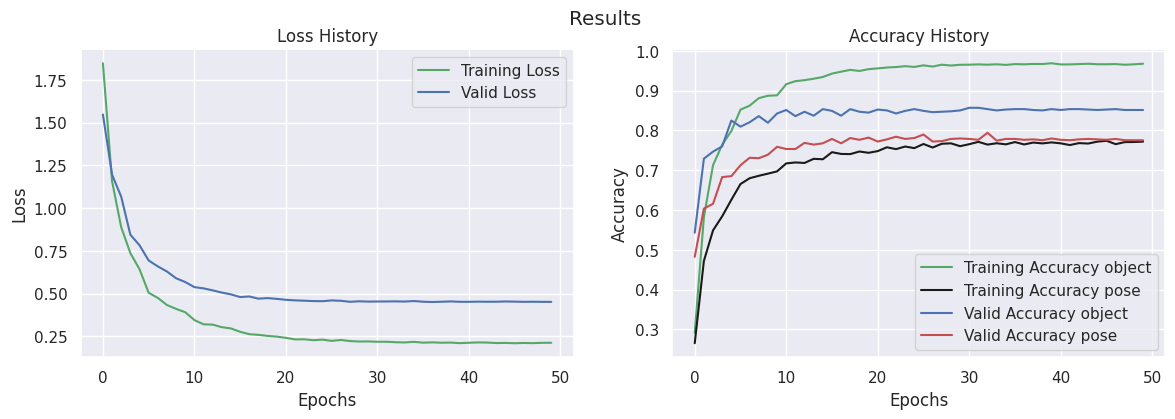

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 31
with a validation loss of: 0.4531931 and a validation accuracy of: 85.68282127380371


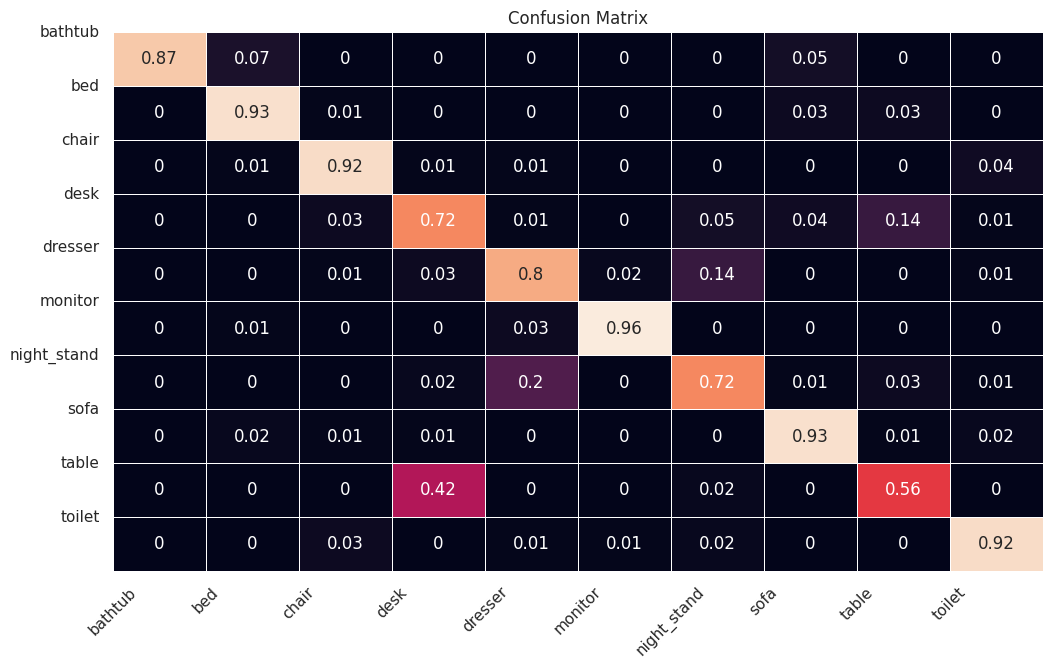

In [ ]:
trainer5.generateConfusionMatrix()

In [ ]:
trainer5.test_on_missing_data()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet_a'
}    

trainer6 = VoxNet_Trainer(training_hyperparameters)
trainer6.train()

model DMPVoxNet was choosen
125.0


Train loss: 1.410643219947815: : 125it [01:01,  2.05it/s]
29it [00:03,  9.45it/s]


epoch:  1 / 50
time: 64.17 seconds
train-loss: 1.92, train-acc-object: 25.66%, train-acc-pose: 26.37%
valid-loss: 1.62, valid-acc-object: 54.30%, train-acc-pose: 47.58%



Train loss: 1.001100778579712: : 125it [00:59,  2.09it/s]
29it [00:03,  9.13it/s]


epoch:  2 / 50
time: 63.14 seconds
train-loss: 1.18, train-acc-object: 56.30%, train-acc-pose: 47.37%
valid-loss: 1.21, valid-acc-object: 68.61%, train-acc-pose: 54.85%



Train loss: 0.7730890512466431: : 125it [00:59,  2.09it/s]
29it [00:03,  9.42it/s]


epoch:  3 / 50
time: 62.99 seconds
train-loss: 0.90, train-acc-object: 69.02%, train-acc-pose: 54.59%
valid-loss: 0.98, valid-acc-object: 78.96%, train-acc-pose: 65.97%



Train loss: 0.6872937679290771: : 125it [01:00,  2.08it/s]
29it [00:03,  9.01it/s]


epoch:  4 / 50
time: 63.33 seconds
train-loss: 0.73, train-acc-object: 76.50%, train-acc-pose: 60.03%
valid-loss: 1.11, valid-acc-object: 69.38%, train-acc-pose: 68.83%



Train loss: 0.6960116624832153: : 125it [00:59,  2.09it/s]
29it [00:03,  8.93it/s]


epoch:  5 / 50
time: 63.07 seconds
train-loss: 0.64, train-acc-object: 79.50%, train-acc-pose: 63.91%
valid-loss: 0.81, valid-acc-object: 79.41%, train-acc-pose: 68.94%



Train loss: 0.5897345542907715: : 125it [00:59,  2.09it/s]
29it [00:03,  7.37it/s]


epoch:  6 / 50
time: 63.85 seconds
train-loss: 0.52, train-acc-object: 84.41%, train-acc-pose: 67.55%
valid-loss: 0.67, valid-acc-object: 79.63%, train-acc-pose: 73.57%



Train loss: 0.44289472699165344: : 125it [01:00,  2.08it/s]
29it [00:04,  6.91it/s]


epoch:  7 / 50
time: 64.31 seconds
train-loss: 0.47, train-acc-object: 86.48%, train-acc-pose: 68.16%
valid-loss: 0.62, valid-acc-object: 82.05%, train-acc-pose: 72.36%



Train loss: 0.5687493681907654: : 125it [01:00,  2.08it/s]
29it [00:04,  6.73it/s]


epoch:  8 / 50
time: 64.52 seconds
train-loss: 0.43, train-acc-object: 87.29%, train-acc-pose: 69.80%
valid-loss: 0.64, valid-acc-object: 83.37%, train-acc-pose: 75.33%



Train loss: 0.5676746368408203: : 125it [01:00,  2.08it/s]
29it [00:04,  6.92it/s]


epoch:  9 / 50
time: 64.22 seconds
train-loss: 0.41, train-acc-object: 88.64%, train-acc-pose: 70.25%
valid-loss: 0.61, valid-acc-object: 81.72%, train-acc-pose: 74.78%



Train loss: 0.3708518147468567: : 125it [01:00,  2.08it/s]
29it [00:04,  7.14it/s]


epoch: 10 / 50
time: 64.26 seconds
train-loss: 0.39, train-acc-object: 89.53%, train-acc-pose: 69.89%
valid-loss: 0.58, valid-acc-object: 83.48%, train-acc-pose: 75.88%



Train loss: 0.2902818024158478: : 125it [01:00,  2.07it/s]
29it [00:03,  7.48it/s]


epoch: 11 / 50
time: 64.15 seconds
train-loss: 0.34, train-acc-object: 91.62%, train-acc-pose: 72.04%
valid-loss: 0.53, valid-acc-object: 83.92%, train-acc-pose: 75.77%



Train loss: 0.38936647772789: : 125it [01:00,  2.07it/s]
29it [00:03,  7.55it/s]


epoch: 12 / 50
time: 64.16 seconds
train-loss: 0.33, train-acc-object: 92.26%, train-acc-pose: 72.37%
valid-loss: 0.51, valid-acc-object: 85.79%, train-acc-pose: 76.76%



Train loss: 0.2602289021015167: : 125it [01:01,  2.04it/s]
29it [00:03,  8.32it/s]


epoch: 13 / 50
time: 64.63 seconds
train-loss: 0.31, train-acc-object: 93.09%, train-acc-pose: 73.18%
valid-loss: 0.50, valid-acc-object: 85.57%, train-acc-pose: 76.65%



Train loss: 0.36062920093536377: : 125it [01:00,  2.06it/s]
29it [00:03,  8.81it/s]


epoch: 14 / 50
time: 64.13 seconds
train-loss: 0.30, train-acc-object: 93.25%, train-acc-pose: 72.99%
valid-loss: 0.51, valid-acc-object: 83.59%, train-acc-pose: 76.87%



Train loss: 0.2807857394218445: : 125it [01:00,  2.05it/s]
29it [00:03,  8.86it/s]


epoch: 15 / 50
time: 64.20 seconds
train-loss: 0.29, train-acc-object: 93.64%, train-acc-pose: 73.33%
valid-loss: 0.49, valid-acc-object: 84.69%, train-acc-pose: 78.63%



Train loss: 0.3443874716758728: : 125it [01:01,  2.04it/s]
29it [00:03,  8.91it/s]


epoch: 16 / 50
time: 64.43 seconds
train-loss: 0.27, train-acc-object: 94.21%, train-acc-pose: 74.79%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.42%



Train loss: 0.23592782020568848: : 125it [01:00,  2.05it/s]
29it [00:03,  9.01it/s]


epoch: 17 / 50
time: 64.07 seconds
train-loss: 0.26, train-acc-object: 94.94%, train-acc-pose: 74.33%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 77.42%



Train loss: 0.28399166464805603: : 125it [01:01,  2.03it/s]
29it [00:03,  8.29it/s]


epoch: 18 / 50
time: 65.07 seconds
train-loss: 0.26, train-acc-object: 95.04%, train-acc-pose: 74.59%
valid-loss: 0.46, valid-acc-object: 84.58%, train-acc-pose: 78.41%



Train loss: 0.1376815140247345: : 125it [01:01,  2.04it/s]
29it [00:03,  8.72it/s]


epoch: 19 / 50
time: 64.52 seconds
train-loss: 0.25, train-acc-object: 95.07%, train-acc-pose: 74.58%
valid-loss: 0.45, valid-acc-object: 85.57%, train-acc-pose: 78.19%



Train loss: 0.3291137218475342: : 125it [01:00,  2.05it/s]
29it [00:03,  8.77it/s]


epoch: 20 / 50
time: 64.32 seconds
train-loss: 0.25, train-acc-object: 94.91%, train-acc-pose: 75.50%
valid-loss: 0.45, valid-acc-object: 85.57%, train-acc-pose: 79.07%



Train loss: 0.3407759666442871: : 125it [01:00,  2.05it/s]
29it [00:03,  8.88it/s]


epoch: 21 / 50
time: 64.18 seconds
train-loss: 0.24, train-acc-object: 95.76%, train-acc-pose: 75.26%
valid-loss: 0.45, valid-acc-object: 85.02%, train-acc-pose: 78.41%



Train loss: 0.19014182686805725: : 125it [01:01,  2.04it/s]
29it [00:03,  8.78it/s]


epoch: 22 / 50
time: 64.52 seconds
train-loss: 0.23, train-acc-object: 96.05%, train-acc-pose: 76.01%
valid-loss: 0.45, valid-acc-object: 85.35%, train-acc-pose: 78.63%



Train loss: 0.19341498613357544: : 125it [01:01,  2.04it/s]
29it [00:03,  8.69it/s]


epoch: 23 / 50
time: 64.75 seconds
train-loss: 0.23, train-acc-object: 95.95%, train-acc-pose: 75.52%
valid-loss: 0.44, valid-acc-object: 84.91%, train-acc-pose: 78.52%



Train loss: 0.2631567716598511: : 125it [01:01,  2.04it/s]
29it [00:03,  8.59it/s]


epoch: 24 / 50
time: 64.74 seconds
train-loss: 0.23, train-acc-object: 96.28%, train-acc-pose: 75.88%
valid-loss: 0.44, valid-acc-object: 85.46%, train-acc-pose: 78.96%



Train loss: 0.23467357456684113: : 125it [01:01,  2.03it/s]
29it [00:03,  8.63it/s]


epoch: 25 / 50
time: 64.82 seconds
train-loss: 0.23, train-acc-object: 96.11%, train-acc-pose: 76.16%
valid-loss: 0.44, valid-acc-object: 85.90%, train-acc-pose: 79.19%



Train loss: 0.2559582591056824: : 125it [01:01,  2.03it/s]
29it [00:03,  8.58it/s]


epoch: 26 / 50
time: 64.86 seconds
train-loss: 0.22, train-acc-object: 96.04%, train-acc-pose: 76.55%
valid-loss: 0.44, valid-acc-object: 84.69%, train-acc-pose: 80.07%



Train loss: 0.25791552662849426: : 125it [01:01,  2.03it/s]
29it [00:03,  8.40it/s]


epoch: 27 / 50
time: 65.07 seconds
train-loss: 0.22, train-acc-object: 96.55%, train-acc-pose: 76.45%
valid-loss: 0.44, valid-acc-object: 85.68%, train-acc-pose: 79.74%



Train loss: 0.2602751851081848: : 125it [01:01,  2.03it/s]
29it [00:03,  8.43it/s]


epoch: 28 / 50
time: 64.90 seconds
train-loss: 0.22, train-acc-object: 96.36%, train-acc-pose: 76.76%
valid-loss: 0.44, valid-acc-object: 85.46%, train-acc-pose: 78.74%



Train loss: 0.1965944617986679: : 125it [01:01,  2.02it/s]
29it [00:03,  8.57it/s]


epoch: 29 / 50
time: 65.20 seconds
train-loss: 0.22, train-acc-object: 96.45%, train-acc-pose: 77.09%
valid-loss: 0.44, valid-acc-object: 84.91%, train-acc-pose: 80.29%



Train loss: 0.23686416447162628: : 125it [01:01,  2.02it/s]
29it [00:03,  8.19it/s]


epoch: 30 / 50
time: 65.42 seconds
train-loss: 0.22, train-acc-object: 96.47%, train-acc-pose: 76.48%
valid-loss: 0.44, valid-acc-object: 85.68%, train-acc-pose: 78.96%



Train loss: 0.1697613000869751: : 125it [01:02,  2.01it/s]
29it [00:03,  8.63it/s]


epoch: 31 / 50
time: 65.51 seconds
train-loss: 0.21, train-acc-object: 96.49%, train-acc-pose: 77.13%
valid-loss: 0.44, valid-acc-object: 85.68%, train-acc-pose: 79.63%



Train loss: 0.2159716635942459: : 125it [01:01,  2.02it/s]
29it [00:03,  8.72it/s]


epoch: 32 / 50
time: 65.15 seconds
train-loss: 0.21, train-acc-object: 96.54%, train-acc-pose: 77.24%
valid-loss: 0.44, valid-acc-object: 85.46%, train-acc-pose: 79.41%



Train loss: 0.24892355501651764: : 125it [01:01,  2.02it/s]
29it [00:03,  7.78it/s]


epoch: 33 / 50
time: 65.74 seconds
train-loss: 0.21, train-acc-object: 96.54%, train-acc-pose: 77.38%
valid-loss: 0.44, valid-acc-object: 85.46%, train-acc-pose: 79.74%



Train loss: 0.17017170786857605: : 125it [01:02,  2.01it/s]
29it [00:04,  7.21it/s]


epoch: 34 / 50
time: 66.21 seconds
train-loss: 0.21, train-acc-object: 96.59%, train-acc-pose: 77.05%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 80.73%



Train loss: 0.20548351109027863: : 125it [01:01,  2.02it/s]
29it [00:04,  6.45it/s]


epoch: 35 / 50
time: 66.35 seconds
train-loss: 0.21, train-acc-object: 96.63%, train-acc-pose: 77.11%
valid-loss: 0.44, valid-acc-object: 85.35%, train-acc-pose: 79.63%



Train loss: 0.13692837953567505: : 125it [01:02,  2.02it/s]
29it [00:04,  7.07it/s]


epoch: 36 / 50
time: 66.14 seconds
train-loss: 0.21, train-acc-object: 96.82%, train-acc-pose: 77.22%
valid-loss: 0.43, valid-acc-object: 85.02%, train-acc-pose: 79.85%



Train loss: 0.2225676327943802: : 125it [01:01,  2.02it/s]
29it [00:04,  7.19it/s]


epoch: 37 / 50
time: 66.02 seconds
train-loss: 0.21, train-acc-object: 96.65%, train-acc-pose: 77.07%
valid-loss: 0.43, valid-acc-object: 85.13%, train-acc-pose: 80.18%



Train loss: 0.23968249559402466: : 125it [01:03,  1.98it/s]
29it [00:03,  8.01it/s]


epoch: 38 / 50
time: 66.77 seconds
train-loss: 0.21, train-acc-object: 96.64%, train-acc-pose: 77.74%
valid-loss: 0.43, valid-acc-object: 85.57%, train-acc-pose: 79.96%



Train loss: 0.15303932130336761: : 125it [01:02,  2.00it/s]
29it [00:03,  8.18it/s]


epoch: 39 / 50
time: 66.17 seconds
train-loss: 0.21, train-acc-object: 96.65%, train-acc-pose: 77.60%
valid-loss: 0.43, valid-acc-object: 85.02%, train-acc-pose: 79.52%



Train loss: 0.22228309512138367: : 125it [01:02,  1.99it/s]
29it [00:03,  7.78it/s]


epoch: 40 / 50
time: 66.71 seconds
train-loss: 0.21, train-acc-object: 96.84%, train-acc-pose: 76.56%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 79.63%



Train loss: 0.19913358986377716: : 125it [01:02,  2.00it/s]
29it [00:03,  8.44it/s]


epoch: 41 / 50
time: 65.89 seconds
train-loss: 0.21, train-acc-object: 96.89%, train-acc-pose: 77.38%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.74%



Train loss: 0.23008906841278076: : 125it [01:02,  2.00it/s]
29it [00:03,  7.37it/s]


epoch: 42 / 50
time: 66.39 seconds
train-loss: 0.21, train-acc-object: 96.72%, train-acc-pose: 77.35%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.85%



Train loss: 0.2073362171649933: : 125it [01:02,  2.02it/s]
29it [00:04,  6.59it/s]


epoch: 43 / 50
time: 66.44 seconds
train-loss: 0.21, train-acc-object: 96.76%, train-acc-pose: 77.31%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 80.07%



Train loss: 0.1626272350549698: : 125it [01:01,  2.03it/s]
29it [00:04,  6.56it/s]


epoch: 44 / 50
time: 66.16 seconds
train-loss: 0.21, train-acc-object: 96.89%, train-acc-pose: 77.61%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 80.51%



Train loss: 0.2323208600282669: : 125it [01:02,  2.00it/s]
29it [00:03,  7.36it/s]


epoch: 45 / 50
time: 66.46 seconds
train-loss: 0.21, train-acc-object: 96.89%, train-acc-pose: 77.54%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 80.29%



Train loss: 0.2262827306985855: : 125it [01:02,  2.01it/s]
29it [00:03,  8.43it/s]


epoch: 46 / 50
time: 65.68 seconds
train-loss: 0.21, train-acc-object: 96.86%, train-acc-pose: 77.31%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 80.29%



Train loss: 0.20919391512870789: : 125it [01:02,  2.01it/s]
29it [00:03,  8.82it/s]


epoch: 47 / 50
time: 65.44 seconds
train-loss: 0.20, train-acc-object: 96.79%, train-acc-pose: 77.36%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 80.51%



Train loss: 0.24676933884620667: : 125it [01:01,  2.02it/s]
29it [00:03,  8.41it/s]


epoch: 48 / 50
time: 65.40 seconds
train-loss: 0.21, train-acc-object: 96.60%, train-acc-pose: 77.44%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.96%



Train loss: 0.24289673566818237: : 125it [01:02,  2.01it/s]
29it [00:03,  8.47it/s]


epoch: 49 / 50
time: 65.67 seconds
train-loss: 0.21, train-acc-object: 96.89%, train-acc-pose: 77.21%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 79.96%



Train loss: 0.17488335072994232: : 125it [01:02,  2.00it/s]
29it [00:03,  7.87it/s]

epoch: 50 / 50
time: 66.20 seconds
train-loss: 0.21, train-acc-object: 96.85%, train-acc-pose: 77.47%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 80.18%



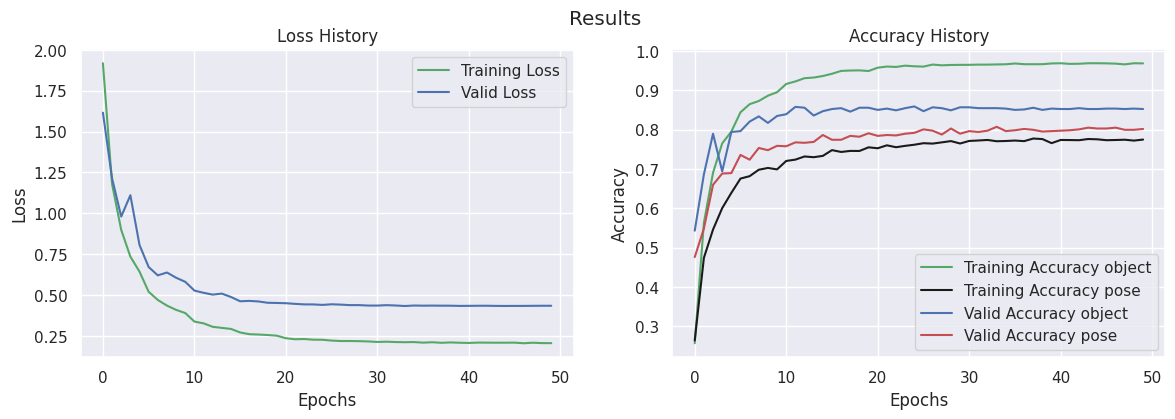

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 25
with a validation loss of: 0.4391984 and a validation accuracy of: 85.90308427810669


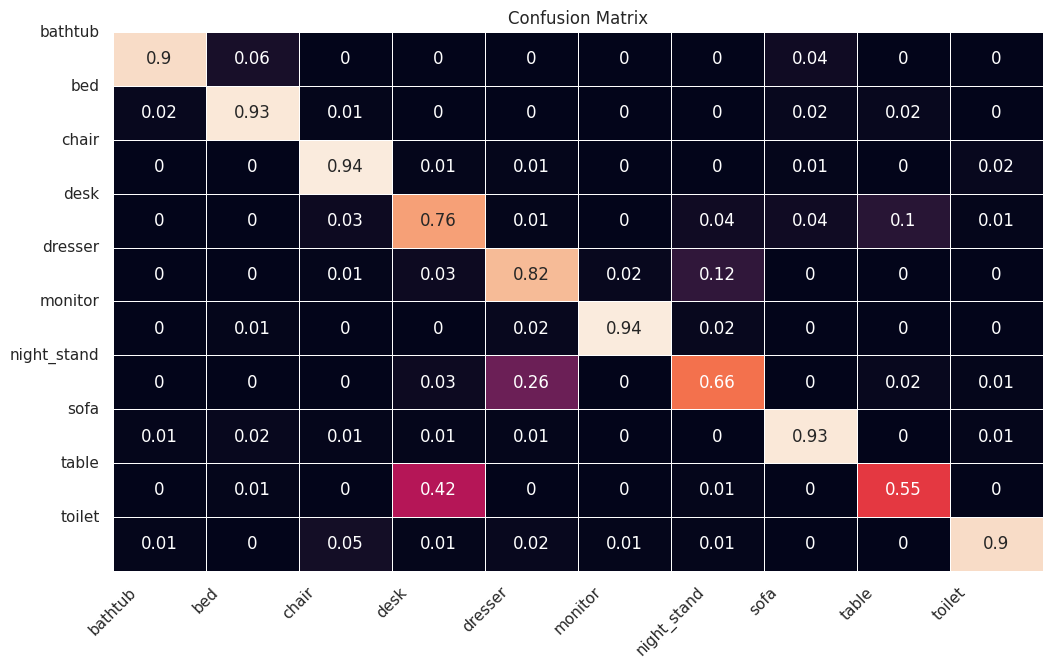

In [ ]:
trainer6.generateConfusionMatrix()

In [ ]:
trainer6.test_on_missing_data()

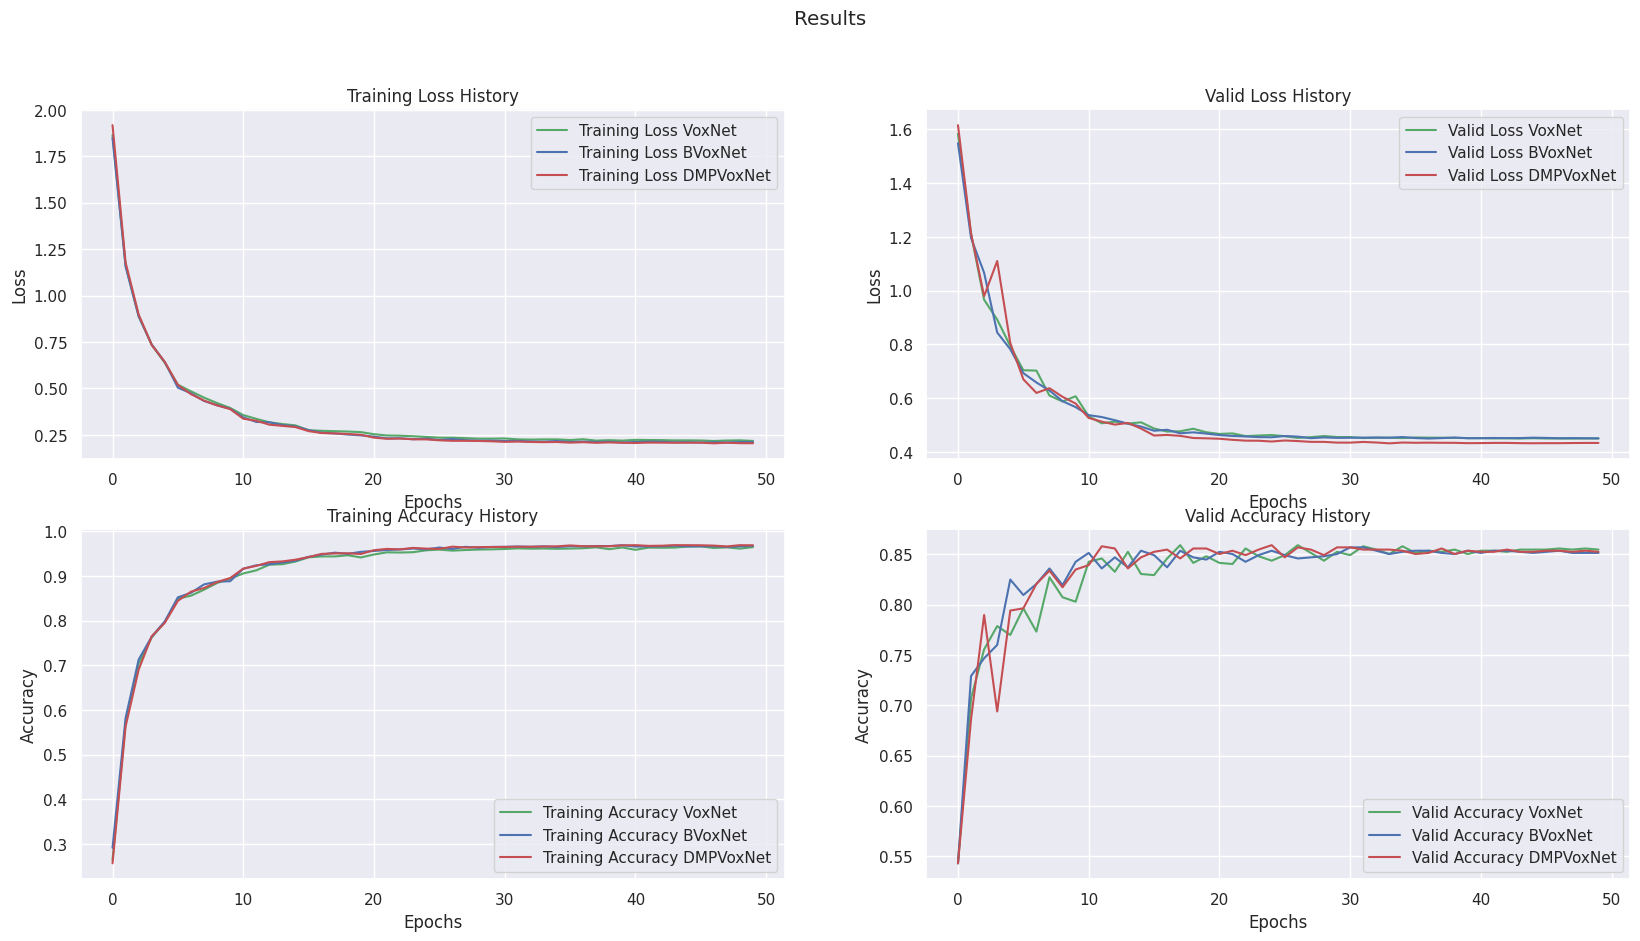

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

model PointNet was chosen
124.71875


Train loss: 0.9222745895385742: : 124it [20:30,  9.92s/it]
15it [03:36, 14.45s/it]


epoch:  1 / 20
time: 1446.94 seconds
train-loss: 1.27, train-acc: 57.71%
valid-loss: 1.39, valid-acc: 51.98%



Train loss: 0.6040809750556946: : 124it [19:10,  9.28s/it]
15it [03:36, 14.40s/it]


epoch:  2 / 20
time: 1366.39 seconds
train-loss: 0.81, train-acc: 72.81%
valid-loss: 0.77, valid-acc: 73.68%



Train loss: 0.5716527104377747: : 3it [00:33, 11.21s/it]


KeyboardInterrupt: ignored

# Download and unzip the dataset ModelNet40



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/ModelNet40.zip";

Output streaming troncato alle ultime 5000 righe.
  inflating: ModelNet40/mantel/train/mantel_0136.off  
  inflating: ModelNet40/mantel/train/mantel_0137.off  
  inflating: ModelNet40/mantel/train/mantel_0138.off  
  inflating: ModelNet40/mantel/train/mantel_0139.off  
  inflating: ModelNet40/mantel/train/mantel_0140.off  
  inflating: ModelNet40/mantel/train/mantel_0141.off  
  inflating: ModelNet40/mantel/train/mantel_0142.off  
  inflating: ModelNet40/mantel/train/mantel_0143.off  
  inflating: ModelNet40/mantel/train/mantel_0144.off  
  inflating: ModelNet40/mantel/train/mantel_0145.off  
  inflating: ModelNet40/mantel/train/mantel_0146.off  
  inflating: ModelNet40/mantel/train/mantel_0147.off  
  inflating: ModelNet40/mantel/train/mantel_0148.off  
  inflating: ModelNet40/mantel/train/mantel_0149.off  
  inflating: ModelNet40/mantel/train/mantel_0150.off  
  inflating: ModelNet40/mantel/train/mantel_0151.off  
  inflating: ModelNet40/mantel/train/mantel_0152.off  
  inflating: Mo

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-16 11:46:17--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-16 11:46:17--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  18.7MB/s    in 62s     

2023-05-16 11:47:20 (31.3 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [7]:
import math
import os
import random

ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

#CLASSES = ['airplane', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
#           'cup', 'curtain', 'door', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
#           'laptop', 'mantel', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
#           'sofa', 'stairs', 'stool', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


 33%|███▎      | 170/515 [00:04<00:08, 40.99it/s]<ipython-input-7-40e10c1620d1>:63: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
 38%|███▊      | 198/515 [00:04<00:04, 77.99it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.
[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 44%|████▎     | 225/515 [00:05<00:05, 53.11it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.
[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 66%|██████▋   | 342/515 [00:11<00:04, 37.42it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 53%|█████▎    | 469/889 [00:18<00:12, 33.47it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


 75%|███████▌  | 669/889 [00:25<00:05, 37.92it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 79%|███████▉  | 704/889 [00:27<00:13, 14.18it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 90%|█████████ | 802/889 [00:32<00:02, 39.27it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 29%|██▉       | 25/86 [00:00<00:00, 73.01it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.


100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


# DMPVoxNet with Modelnet40

In [8]:
class VoxelDataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [14]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      #self.class_names = ['airplane', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
      #                    'cup', 'curtain', 'door', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
      #                    'laptop', 'mantel', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
      #                    'sofa', 'stairs', 'stool', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset40(train=True)
      self.test_ds = VoxelDataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = DMPVoxNet40()
      os.mkdir('/content/'+str(self.name_model))
      print('model DMPVoxNet40 was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)


  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [15]:
from collections import OrderedDict
class DMPVoxNet40(nn.Module):
    def __init__(self):
        super(DMPVoxNet40, self).__init__()
        n_classes = 34
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=128, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [16]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet40'
}    

trainer8 = VoxNet_Trainer40(training_hyperparameters)
trainer8.train()

model DMPVoxNet40 was choosen


TypeError: ignored

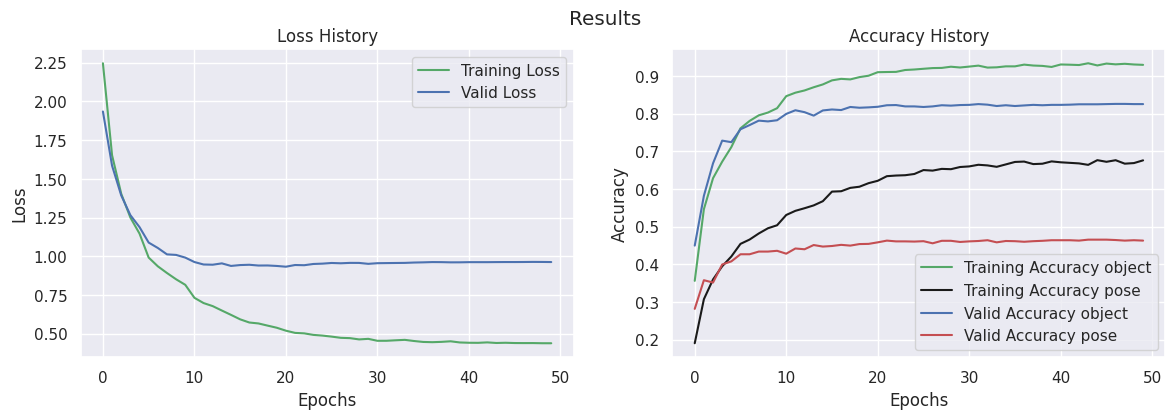

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 47
with a validation loss of: 0.9630649 and a validation accuracy of: 82.55102038383484


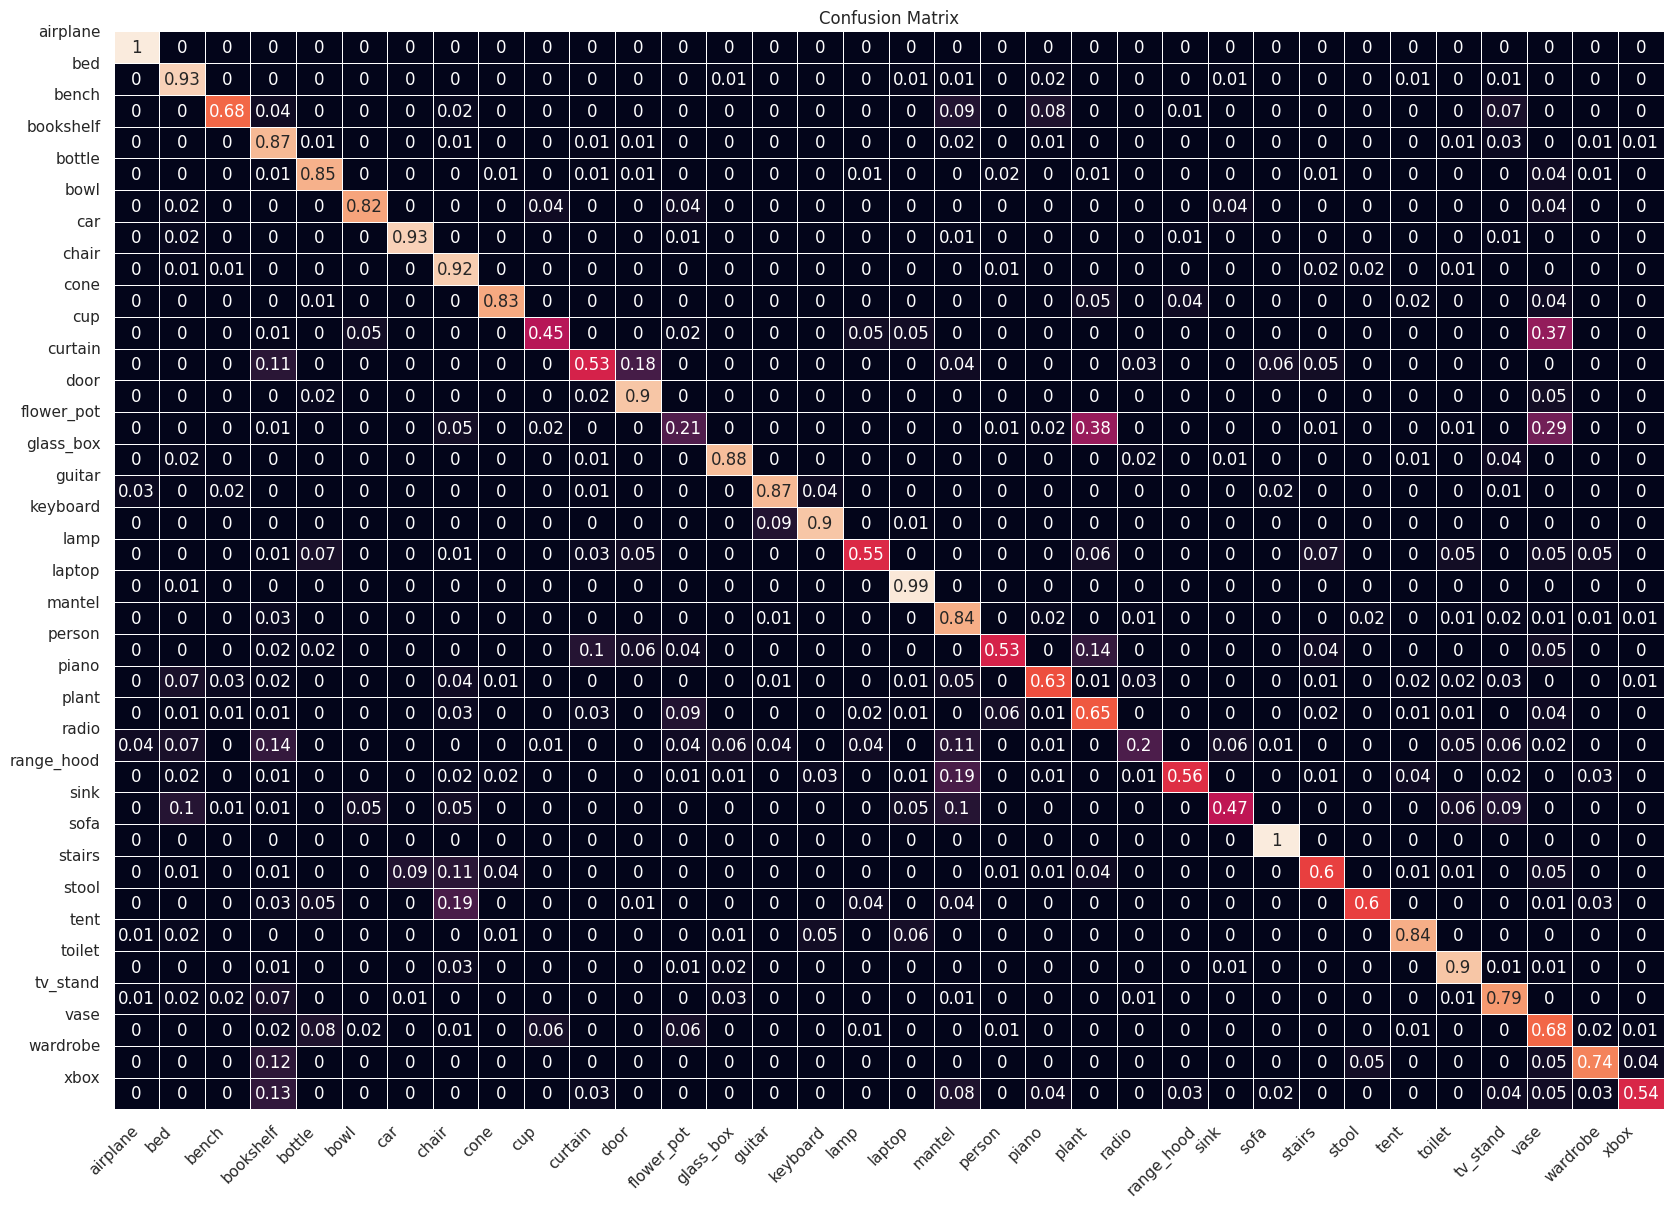

In [ ]:
trainer8.generateConfusionMatrix()